# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import time

initial_start_time = time.time()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
# magic word for producing visualizations in notebook
%matplotlib inline

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

In [2]:
import matplotlib as mpl
mpl.style.use('seaborn')

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [3]:
# Load in the general demographics data.
general = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep = ';')
# general_test = general.copy()
# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep = ';')
# feat_info_test = feat_info.copy()

In [4]:
# Load in the customers demographics file.
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", sep = ';')

In [5]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(general.shape)
general.head()

(891221, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [6]:
print(customers.shape)
customers.head()

(191652, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [7]:
print(feat_info.shape)
feat_info.head()

(85, 4)


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [8]:
print(f'The shape of the general dataframe before any data is preprocessed is {general.shape}')

The shape of the general dataframe before any data is preprocessed is (891221, 85)


In [9]:
print(f'Program elapse time is {time.time() - initial_start_time}')

Program elapse time is 11.95383906364441


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [10]:
# Identify missing or unknown data values and convert them to NaNs.
# the total number of NaNs is:
preprocessing_NaNs = general.isna().sum().sum()
print(f'The number of NaNs in the general dataframe before any data is preprocessed is {preprocessing_NaNs}')

The number of NaNs in the general dataframe before any data is preprocessed is 4896838


In [11]:
# the number of NaNs by column, before converting value codes into NANs, is:
nans_by_columns_before = general.isna().sum()
nans_by_columns_before.iloc[ :5]

AGER_TYP                   0
ALTERSKATEGORIE_GROB       0
ANREDE_KZ                  0
CJT_GESAMTTYP           4854
FINANZ_MINIMALIST          0
dtype: int64

In [12]:
# the number of NaNs by row, before converting value codes into NANs, is:
nans_by_rows_before = general.isna().sum(axis=1)
nans_by_rows_before.iloc[ :5]

0    42
1     1
2     1
3     2
4     0
dtype: int64

In [13]:
feat_info_unique_unknown = feat_info['missing_or_unknown'].unique()
feat_info_unique_unknown

array(['[-1,0]', '[-1,0,9]', '[0]', '[-1]', '[]', '[-1,9]', '[-1,X]',
       '[XX]', '[-1,XX]'], dtype=object)

In [14]:
# the missing_unknown_dict will allow conversion of text objects into list objects for each column
missing_unknown_dict = {}
for value in feat_info_unique_unknown:
    if value == '[]':
        value_list = []
    else:
        cleaned_value = value.strip('[]').split(',')
        value_list = []
        for cleaned in cleaned_value:
            try:
                value_list.append(int(cleaned))
            except:
                value_list.append(cleaned) # needed for the '[]', 'X', and 'XX' entries
    missing_unknown_dict[value] = value_list
missing_unknown_dict

{'[-1,0]': [-1, 0],
 '[-1,0,9]': [-1, 0, 9],
 '[0]': [0],
 '[-1]': [-1],
 '[]': [],
 '[-1,9]': [-1, 9],
 '[-1,X]': [-1, 'X'],
 '[XX]': ['XX'],
 '[-1,XX]': [-1, 'XX']}

In [15]:
# text is replaced by integers or text in lists
for column in general.columns:
    attribute = feat_info.loc[feat_info['attribute'] == column]
    string_list = attribute['missing_or_unknown']
    real_list = missing_unknown_dict[string_list.iloc[0]] 
    general[column].replace(real_list, (len(real_list) * [np.nan]), inplace=True)

In [16]:
# The number of NaNS before preproceesing was 4896838.
after_converting_NaNs = general.isna().sum().sum()
print(f'The number of NaNs in the general dataframe after converting the value codes to NaNs is {after_converting_NaNs}')
print(f'The number of NaNs added to the general data frame is {after_converting_NaNs - preprocessing_NaNs}')

The number of NaNs in the general dataframe after converting the value codes to NaNs is 8373929
The number of NaNs added to the general data frame is 3477091


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

***Note:***
To maintain a consistent manner of cleaning the data. 
Rows and columns with over 20 percent NaNs will be removed. 

In [17]:
# Perform an assessment of how much missing data there is in each column of the dataset.
# the number of NaNs by column, after converting value codes into NANs, in descending order is:
nans_columns_after = general.isna().sum()
nans_columns_after_sorted = nans_columns_after.sort_values(ascending=False)
nans_columns_after_sorted[ :5] 

TITEL_KZ        889061
AGER_TYP        685843
KK_KUNDENTYP    584612
KBA05_BAUMAX    476524
GEBURTSJAHR     392318
dtype: int64

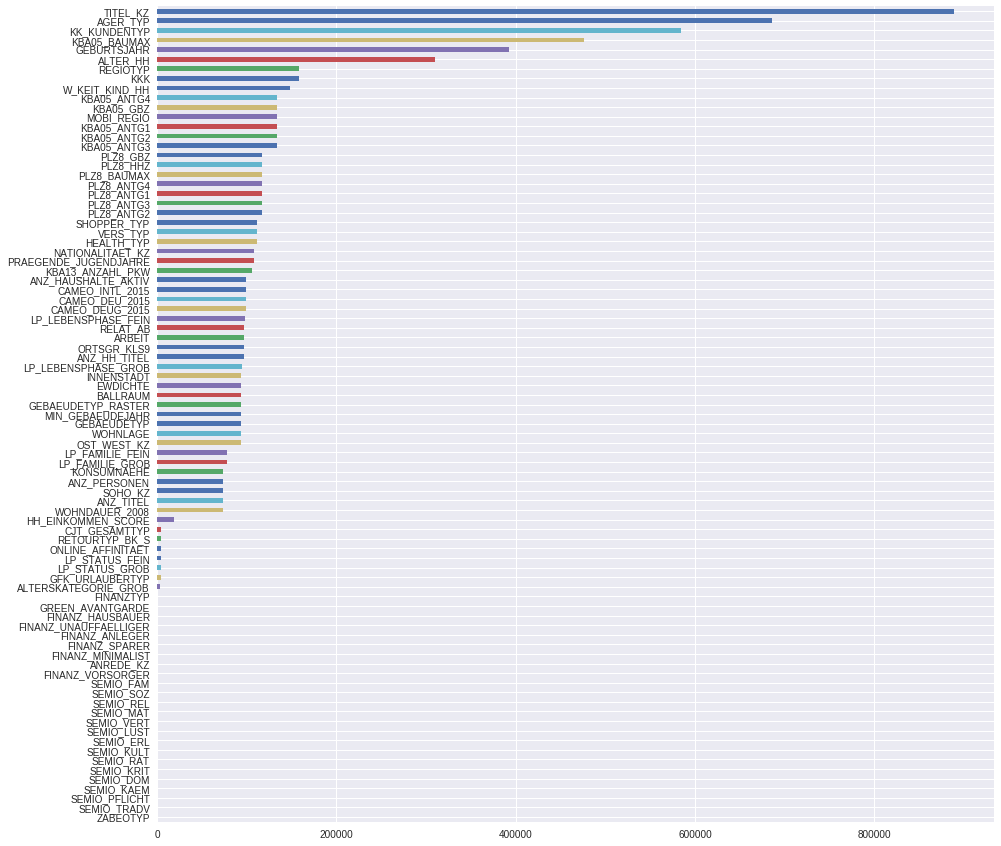

In [18]:
# Investigate patterns in the amount of missing data in each column.
nans_columns_after.sort_values().plot.barh(figsize=(15,15))

In [19]:
column_cutoff_value = 178244 # this value is equal to 20% of the rows
# percent of NaNs for each column above the cutoff value
nans_columns_after_sorted[nans_columns_after_sorted  > column_cutoff_value]/general.shape[0] 

TITEL_KZ        0.997576
AGER_TYP        0.769554
KK_KUNDENTYP    0.655967
KBA05_BAUMAX    0.534687
GEBURTSJAHR     0.440203
ALTER_HH        0.348137
dtype: float64

In [20]:
above_cutoff_nan_total = nans_columns_after_sorted[nans_columns_after_sorted > column_cutoff_value].sum()
print(f'The number of NaNs above the cutoff is {above_cutoff_nan_total}')
below_cutoff_nan_total = nans_columns_after_sorted[nans_columns_after_sorted <= column_cutoff_value].sum()
print(f'The number of NaNs below the cutoff is {below_cutoff_nan_total}')
# percent of total NaNs above the cutoff value
print(f'Percent of total NaNs above the cutoff value is {(above_cutoff_nan_total /after_converting_NaNs) * 100}')

The number of NaNs above the cutoff is 3338625
The number of NaNs below the cutoff is 5035304
Percent of total NaNs above the cutoff value is 39.869277611501126


In [21]:
above_cutoff_columns = general[general.columns[nans_columns_after > column_cutoff_value]]
print(f'The number of columns to removed is {above_cutoff_columns.shape[1]}')
removed_columns = above_cutoff_columns.columns
print(f'The columns to be removed are {removed_columns}')

The number of columns to removed is 6
The columns to be removed are Index(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX'],
      dtype='object')


In [22]:
below_cutoff_columns = general[general.columns[nans_columns_after <= column_cutoff_value]]

In [23]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
general.drop(removed_columns, axis=1, inplace=True)
print(f'The shape of the general dataframe after dropping columns with over 20% NaNs is {general.shape}')

The shape of the general dataframe after dropping columns with over 20% NaNs is (891221, 79)


In [24]:
print(f'The number of NaNs in the Azdias dataframe after dropping columns with over 20% NaNs is \
{general.isna().sum().sum()}')

The number of NaNs in the Azdias dataframe after dropping columns with over 20% NaNs is 5035304


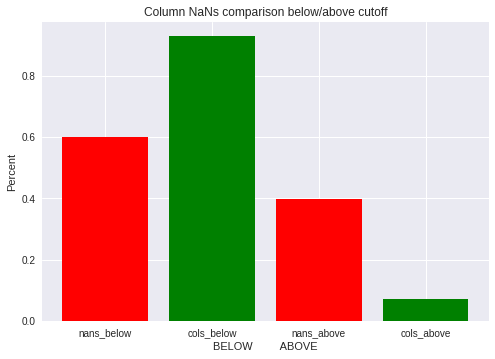

In [25]:
total_columns = below_cutoff_columns.shape[1] + above_cutoff_columns.shape[1]
total_nans = below_cutoff_nan_total + above_cutoff_nan_total
percent_cols = [below_cutoff_nan_total/total_nans, below_cutoff_columns.shape[1]/total_columns, \
                above_cutoff_nan_total/total_nans , above_cutoff_columns.shape[1]/total_columns]
colors = ['red', 'green','red', 'green']
labels_cols = ['nans_below','cols_below','nans_above','cols_above']

plt.xticks(range(len(percent_cols)), labels_cols)
plt.xlabel('BELOW         ABOVE')
plt.ylabel('Percent')
plt.title('Column NaNs comparison below/above cutoff')
plt.bar(range(len(percent_cols)), percent_cols, color=colors) 
plt.show()

In [26]:
print(f'Program elapse time is {time.time() - initial_start_time}')

Program elapse time is 28.771887063980103


#### Discussion 1.1.2: Assess Missing Data in Each Column
I decided to remove the 6 columns that have NaNs above 20% of the column's total of 891221 rows, which is the 'column_cutoff_value' = 178244. 
This will remove about 39% of the dataframes NaNs while retaining 79 of the 85 of the original columns, which is 92.9%.
The next group of columns with lower amount of NaNs, begins at 158064 NaNs which is 17.7% of the rows.  Removing any of these columns would mean columns with valid data 82.3% or greater would be lost.
Using the 20% cutoff value eliminates only columns with valid data of 65.2% or less are removed.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [27]:
# How much data is missing in each row of the dataset?
nans_rows_after = general.isna().sum(axis=1)
nans_rows_after.iloc[:5]

0    43
1     0
2     0
3     7
4     0
dtype: int64

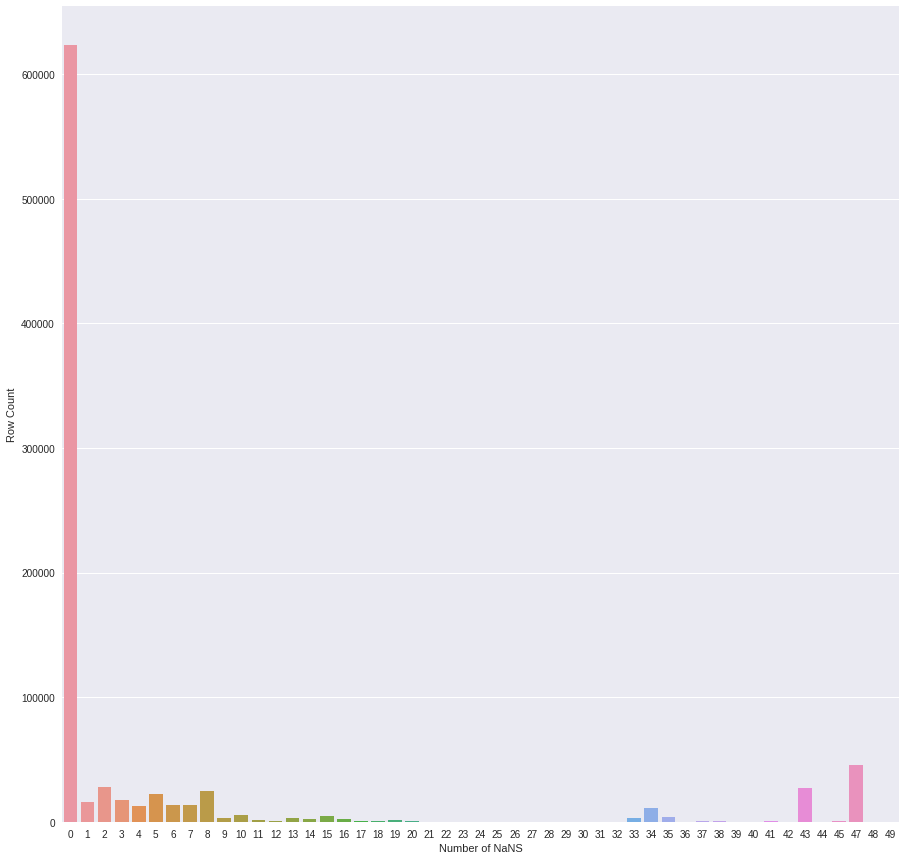

In [28]:
# plot number of rows by number NaNs in each row
plt.figure(figsize=(15, 15))
ax = sns.countplot(nans_rows_after)
ax.set(xlabel='Number of NaNS', ylabel='Row Count')
plt.show()

In [29]:
# show number of rows grouped according to the number NaNs, rows 0, 1-10, 11-20, etc... 
split_beginning = 0
split_list = []
split_value_list = []
for nans_in_row  in range(0, 61, 10):
    row_nans = (nans_rows_after <= nans_in_row).sum()
    split_value = row_nans - split_beginning
    split_list.append(nans_in_row)
    split_value_list.append(split_value)    
    print(nans_in_row, split_value)
    split_beginning = row_nans

0 623209
10 156944
20 17273
30 641
40 19178
50 73976
60 0


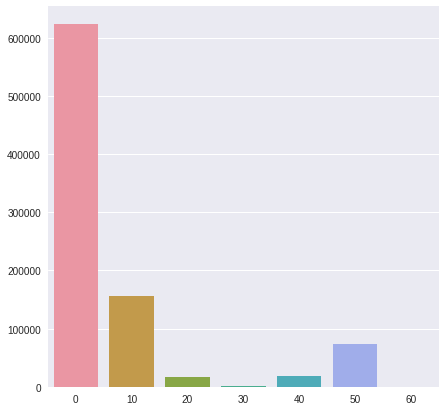

In [30]:
plt.figure(figsize=(7, 7))
sns.barplot(split_list, split_value_list)

In [31]:
# Using a row cutoff value of 16 will remove rows with that 21% or greater NaNs per row.
16/general.shape[1]

0.20253164556962025

In [32]:
row_cutoff_value = 16

In [33]:
# data preparation for bar plot
nans_below = general[nans_rows_after <= row_cutoff_value].isna().sum().sum()
nans_above = general[nans_rows_after > row_cutoff_value].isna().sum().sum()
nans_total = nans_below + nans_above

rows_below = general[nans_rows_after <= row_cutoff_value].shape[0]
rows_above = general[nans_rows_after > row_cutoff_value].shape[0]
rows_total = rows_below + rows_above

percent_rows = [nans_below/nans_total, rows_below/rows_total, nans_above/nans_total, rows_above/rows_total]
percent_rows

[0.18883646349852959,
 0.8918012479508449,
 0.81116353650147044,
 0.10819875204915504]

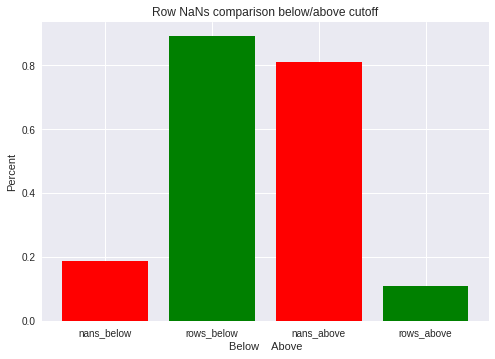

In [34]:
labels_rows = ['nans_below','rows_below','nans_above','rows_above']
plt.xticks(range(len(percent_rows)), labels_rows)
plt.xlabel('Below    Above')
plt.ylabel('Percent')
plt.title('Row NaNs comparison below/above cutoff')
plt.bar(range(len(percent_rows)), percent_rows, color=colors) 
plt.show()

In [35]:
print(f'The number of NaNs above the cutoff value is {general[nans_rows_after > row_cutoff_value].isna().sum().sum()}')

The number of NaNs above the cutoff value is 4084455


In [36]:
print(f'The number of NaNs below the cutoff value is {general[nans_rows_after <= row_cutoff_value].isna().sum().sum()}')

The number of NaNs below the cutoff value is 950849


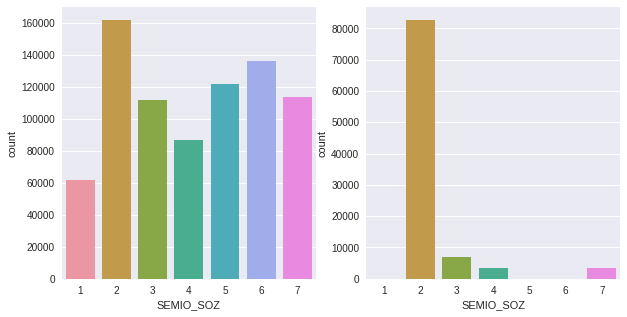

In [37]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
f, axes = plt.subplots(1, 2,figsize=(10,5))
sns.countplot(general['SEMIO_SOZ'][nans_rows_after <= row_cutoff_value], ax=axes[0])
sns.countplot(general['SEMIO_SOZ'][nans_rows_after > row_cutoff_value], ax=axes[1])

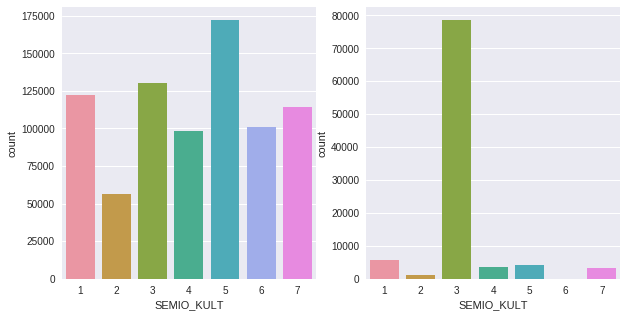

In [38]:
f, axes = plt.subplots(1, 2,figsize=(10,5))
sns.countplot(general['SEMIO_KULT'][nans_rows_after <= row_cutoff_value], ax=axes[0])
sns.countplot(general['SEMIO_KULT'][nans_rows_after > row_cutoff_value], ax=axes[1])

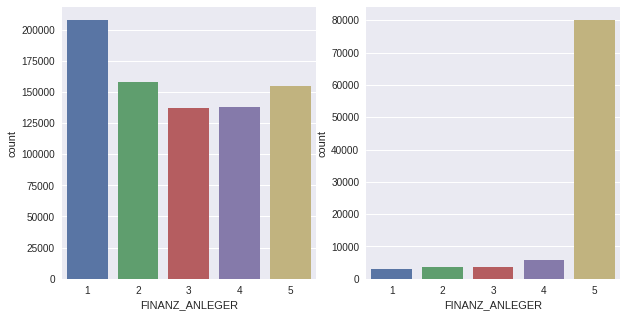

In [39]:
f, axes = plt.subplots(1, 2,figsize=(10,5))
sns.countplot(general['FINANZ_ANLEGER'][nans_rows_after <= row_cutoff_value], ax=axes[0])
sns.countplot(general['FINANZ_ANLEGER'][nans_rows_after > row_cutoff_value], ax=axes[1])

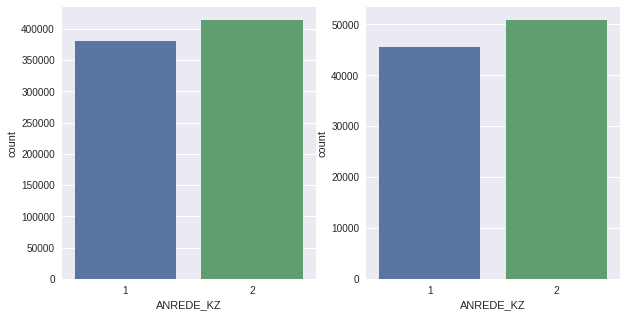

In [40]:
f, axes = plt.subplots(1, 2,figsize=(10,5))
sns.countplot(general['ANREDE_KZ'][nans_rows_after <= row_cutoff_value], ax=axes[0])
sns.countplot(general['ANREDE_KZ'][nans_rows_after > row_cutoff_value], ax=axes[1])

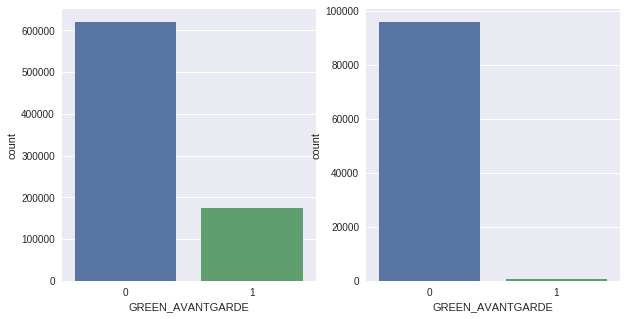

In [41]:
f, axes = plt.subplots(1, 2,figsize=(10,5))
sns.countplot(general['GREEN_AVANTGARDE'][nans_rows_after <= row_cutoff_value], ax=axes[0])
sns.countplot(general['GREEN_AVANTGARDE'][nans_rows_after > row_cutoff_value], ax=axes[1])

In [42]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
above_cutoff_rows = general.loc[nans_rows_after > row_cutoff_value]
print(above_cutoff_rows.isna().sum().sum())
above_cutoff_rows.shape

4084455


(96429, 79)

In [43]:
below_cutoff_rows = general.loc[nans_rows_after <= row_cutoff_value]
print(below_cutoff_rows.isna().sum().sum())
below_cutoff_rows.shape

950849


(794792, 79)

In [44]:
general = below_cutoff_rows
print(f'The shape of the general dataframe after dropping rows with over 21% NaNs is {general.shape}')

The shape of the general dataframe after dropping rows with over 21% NaNs is (794792, 79)


### Note
By removing rows and columns with less than 80% data integrity,
6 columns were removed, dropping from 85 to 79 columns, retaining 93% of the columns.
96429 rows were removed, dropping from 891,221 to 794,792, retaining 89% of the rows.
The number of NaNs removed, from 8,373,929 to 950,849, resulted in a reduction of 89% of NaNs.

In [45]:
print(f'The number of NaNs in the general dataframe after dropping rows with over 21% NaNs is {general.isna().sum().sum()}')

The number of NaNs in the general dataframe after dropping rows with over 21% NaNs is 950849


In [46]:
print(f'Program elapse time is {time.time() - initial_start_time}')

Program elapse time is 42.99742031097412


#### Discussion 1.1.3: Assess Missing Data in Each Row

The above\below plots clearly show that the distribution of the variables are different below and above the cut off value.
This must taken into account when any conclusions are made later in the process of the investigation of this data.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [47]:
# How many features are there of each data type?
feat_info['type'].value_counts()

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

In [48]:
# The 1 interval column was among the 6 columns removed, along with 3 catergorical, 1 mixed, and 1 numeric column.
for name in removed_columns:
    feat_info = feat_info[feat_info['attribute'] != name] # removing the six rows in feat_info
feat_info['type'].value_counts()

ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

In [49]:
for feat in feat_info.columns:
    print(f'{feat} includes these values {feat_info[feat].unique()}')
    print()

attribute includes these values ['ALTERSKATEGORIE_GROB' 'ANREDE_KZ' 'CJT_GESAMTTYP' 'FINANZ_MINIMALIST'
 'FINANZ_SPARER' 'FINANZ_VORSORGER' 'FINANZ_ANLEGER'
 'FINANZ_UNAUFFAELLIGER' 'FINANZ_HAUSBAUER' 'FINANZTYP' 'GFK_URLAUBERTYP'
 'GREEN_AVANTGARDE' 'HEALTH_TYP' 'LP_LEBENSPHASE_FEIN'
 'LP_LEBENSPHASE_GROB' 'LP_FAMILIE_FEIN' 'LP_FAMILIE_GROB' 'LP_STATUS_FEIN'
 'LP_STATUS_GROB' 'NATIONALITAET_KZ' 'PRAEGENDE_JUGENDJAHRE'
 'RETOURTYP_BK_S' 'SEMIO_SOZ' 'SEMIO_FAM' 'SEMIO_REL' 'SEMIO_MAT'
 'SEMIO_VERT' 'SEMIO_LUST' 'SEMIO_ERL' 'SEMIO_KULT' 'SEMIO_RAT'
 'SEMIO_KRIT' 'SEMIO_DOM' 'SEMIO_KAEM' 'SEMIO_PFLICHT' 'SEMIO_TRADV'
 'SHOPPER_TYP' 'SOHO_KZ' 'VERS_TYP' 'ZABEOTYP' 'ANZ_PERSONEN' 'ANZ_TITEL'
 'HH_EINKOMMEN_SCORE' 'W_KEIT_KIND_HH' 'WOHNDAUER_2008'
 'ANZ_HAUSHALTE_AKTIV' 'ANZ_HH_TITEL' 'GEBAEUDETYP' 'KONSUMNAEHE'
 'MIN_GEBAEUDEJAHR' 'OST_WEST_KZ' 'WOHNLAGE' 'CAMEO_DEUG_2015'
 'CAMEO_DEU_2015' 'CAMEO_INTL_2015' 'KBA05_ANTG1' 'KBA05_ANTG2'
 'KBA05_ANTG3' 'KBA05_ANTG4' 'KBA05_GBZ' 'BALLRAUM' 'EW

In [50]:
# all of the ordinal value columns and their unique values
ordinal_values = feat_info.loc[feat_info['type'] == 'ordinal']['attribute']
for column in general[ordinal_values]:
    print(column)
    print(general[ordinal_values][column].unique())

ALTERSKATEGORIE_GROB
[  1.   3.   4.   2.  nan]
FINANZ_MINIMALIST
[1 4 3 2 5]
FINANZ_SPARER
[5 4 2 3 1]
FINANZ_VORSORGER
[2 1 5 4 3]
FINANZ_ANLEGER
[5 2 1 4 3]
FINANZ_UNAUFFAELLIGER
[4 3 1 2 5]
FINANZ_HAUSBAUER
[5 2 3 4 1]
HEALTH_TYP
[  3.   2.   1.  nan]
RETOURTYP_BK_S
[  1.   3.   2.   5.   4.  nan]
SEMIO_SOZ
[5 4 6 2 7 3 1]
SEMIO_FAM
[4 1 5 7 2 6 3]
SEMIO_REL
[4 3 2 7 5 1 6]
SEMIO_MAT
[3 1 2 4 7 5 6]
SEMIO_VERT
[1 4 7 2 6 5 3]
SEMIO_LUST
[2 4 6 7 3 1 5]
SEMIO_ERL
[2 6 7 4 5 1 3]
SEMIO_KULT
[3 4 6 5 7 1 2]
SEMIO_RAT
[6 4 3 2 7 5 1]
SEMIO_KRIT
[4 7 3 1 5 6 2]
SEMIO_DOM
[7 4 2 1 5 6 3]
SEMIO_KAEM
[4 7 5 2 3 6 1]
SEMIO_PFLICHT
[7 3 4 5 1 6 2]
SEMIO_TRADV
[6 3 4 2 7 5 1]
HH_EINKOMMEN_SCORE
[ 6.  4.  1.  5.  3.  2.]
W_KEIT_KIND_HH
[  3.  nan   2.   6.   5.   4.   1.]
WOHNDAUER_2008
[ 9.  8.  3.  4.  5.  6.  2.  7.  1.]
KONSUMNAEHE
[  1.   5.   4.   3.   2.   6.   7.  nan]
KBA05_ANTG1
[  0.   1.   4.   2.   3.  nan]
KBA05_ANTG2
[  0.   3.   1.   4.   2.  nan]
KBA05_ANTG3
[  0.   1.  nan   

In [51]:
# all of the numeric value columns and their unique values
numeric_values = feat_info.loc[feat_info['type'] == 'numeric']['attribute']
for column in general[numeric_values]:
    print(column)
    print(general[numeric_values][column].unique())

ANZ_PERSONEN
[  2.   1.   0.   4.   3.   5.   6.   7.   8.  12.   9.  21.  10.  13.  11.
  14.  45.  20.  31.  37.  16.  22.  15.  23.  18.  35.  17.  40.  38.]
ANZ_TITEL
[ 0.  1.  2.  4.  3.]
ANZ_HAUSHALTE_AKTIV
[  11.   10.    1.    3.    5.    4.    6.    2.    9.   nan   14.   13.
    8.    7.   44.   25.   36.   16.  272.   33.   15.   12.   22.   21.
   20.   67.   23.   18.   27.   24.   31.   39.   19.   30.   17.   29.
   61.   54.   88.   49.   60.   38.   34.   48.   35.   62.   26.   45.
   42.   28.   77.   47.   50.  236.  137.   43.   52.   41.   76.   63.
   32.   40.   37.   59.   53.   57.  118.   66.   95.   78.   70.   46.
  185.   73.  154.   80.  102.   92.  126.   94.   71.   68.   81.   69.
  121.  258.   58.   86.  124.   85.   90.  128.   51.   72.   64.   56.
   83.  150.  259.   91.  160.  134.  169.  246.   82.  114.  183.  116.
   74.  143.   99.  216.   98.  125.  112.  123.   55.  120.   75.  141.
  103.   87.   89.  223.   93.  179.  135.  149.   97.  1

In [52]:
# there are no interval values columns, it was 1 of the 6 columns removed earlier
interval_values = feat_info.loc[feat_info['type'] == 'interval']['attribute']
interval_values

Series([], Name: attribute, dtype: object)

### The numeric and ordianal value columns will not be re-encoded. ###

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

### Assess categorical variables: which are binary, which are multi-level, and which ones needs to be encoded ###

In [53]:
# all of the categorical value columns and their unique values
categorical_values = feat_info.loc[feat_info['type'] == 'categorical']['attribute']
for column in general[categorical_values]:
    print(column)
    print(general[categorical_values][column].unique())

ANREDE_KZ
[2 1]
CJT_GESAMTTYP
[  5.   3.   2.   4.   1.   6.  nan]
FINANZTYP
[1 6 5 2 4 3]
GFK_URLAUBERTYP
[ 10.   1.   5.  12.   9.   3.   8.  11.   4.   7.   2.   6.  nan]
GREEN_AVANTGARDE
[0 1]
LP_FAMILIE_FEIN
[  5.   1.  nan  10.   2.   7.  11.   8.   4.   6.   9.   3.]
LP_FAMILIE_GROB
[  3.   1.  nan   5.   2.   4.]
LP_STATUS_FEIN
[  2.   3.   9.   4.   1.  10.   5.   8.   6.   7.  nan]
LP_STATUS_GROB
[  1.   2.   4.   5.   3.  nan]
NATIONALITAET_KZ
[  1.   3.   2.  nan]
SHOPPER_TYP
[  3.   2.   1.   0.  nan]
SOHO_KZ
[ 1.  0.]
VERS_TYP
[  2.   1.  nan]
ZABEOTYP
[5 3 4 1 6 2]
GEBAEUDETYP
[ 8.  1.  3.  2.  6.  4.  5.]
OST_WEST_KZ
['W' 'O']
CAMEO_DEUG_2015
['8' '4' '2' '6' '1' '9' '5' '7' '3' nan]
CAMEO_DEU_2015
['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D' '9E'
 '9B' '1B' '3D' nan '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C' '9C'
 '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F' '5F' '1C']


#### The following columns are defined as binary catergories:

In [54]:
categorical_binary_list = ['ANREDE_KZ','GREEN_AVANTGARDE','SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

#### The following columns are defined as one hot encoded.

In [55]:
categorical_one_hot_list = ['CJT_GESAMTTYP', 'FINANZTYP','GFK_URLAUBERTYP','LP_FAMILIE_FEIN',
               'LP_STATUS_FEIN', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP',
                'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']

#### These 2 columns are coarse measurement catergories that have with fine measurement catergories of the same type, so they are redundant and will be removed

In [56]:
general = general.drop(['LP_FAMILIE_GROB','LP_STATUS_GROB'],axis=1)
print(f'The shape of the Azdias dataframe, after these two columns are dropped, is {general.shape}')

The shape of the Azdias dataframe, after these two columns are dropped, is (794792, 77)


In [57]:
removed_columns_list = list(removed_columns) # convert pd.series to a list for ease of use 
removed_columns_list.append('LP_FAMILIE_GROB') # coarse values
removed_columns_list.append('LP_STATUS_GROB') # coarse values

#### alphanumeric values in 'CAMEO_DEU_2015' needed  to be converted to a numeric sequence

In [58]:
cameo_due_2015_list = [value for value in general['CAMEO_DEU_2015'].unique() if value is not np.nan] # don't process NaNs
cameo_due_2015_list.sort() # sort for consistent ordering for the dictionary
cameo_due_2015_dict = {value: count for count, value in enumerate(cameo_due_2015_list)}

In [59]:
# re-encode column
general['CAMEO_DEU_2015'] = general['CAMEO_DEU_2015'].apply(lambda row : cameo_due_2015_dict.get(row, np.nan))

####  'OST_WEST_KZ' needs to be re-encoded from 'W', 'O' to 0, 1

In [60]:
general['OST_WEST_KZ'].replace(['W', 'O'], [0, 1], inplace=True)

#### Discussion 1.2.1: Re-Encode Categorical Features

The **categorical_binary_list** = ['ANREDE_KZ','GREEN_AVANTGARDE','SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ'] contains binary features that need no reengineering, they have just 2 states.

The **categorical_one_hot_list** = ['CJT_GESAMTTYP', 'FINANZTYP','GFK_URLAUBERTYP','LP_FAMILIE_FEIN',
               'LP_STATUS_FEIN', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP',
                'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']                
contains the catergorical values that have more than 2 states so we will one hot encode them.

The alphanumeric values in **'CAMEO_DEU_2015'** needed to to be converted to a numeric sequence

The 2 coarse measurements **'LP_FAMILIE_GROB'** and **'LP_STATUS_GROB'** will be dropped as there are fine measurement features, **LP_FAMILIE_FEIN** and **LP_STATUS_FEIN** that make them redundant.

The alphanumeric values in **'CAMEO_DEU_2015'** were converted to a numeric sequence.

The **OST_WEST_KZ** variable was re-encoded from 'W', 'O' to 0, 1.

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [61]:
# all of the mixed value columns and their unique values
mixed_values = feat_info.loc[feat_info['type'] == 'mixed']['attribute']
for column in general[mixed_values]:
    print(column)
    print(general[mixed_values][column].unique())

LP_LEBENSPHASE_FEIN
[ 21.   3.  nan  32.   8.   2.   5.  10.   4.   6.  23.  12.  20.   1.  25.
  13.  18.  31.  38.  35.  30.   7.  22.  14.  29.  24.  28.  37.  26.  39.
  27.  36.   9.  34.  33.  15.  11.  40.  16.  19.  17.]
LP_LEBENSPHASE_GROB
[  6.   1.  nan  10.   2.   3.   5.   7.  12.  11.   9.   4.   8.]
PRAEGENDE_JUGENDJAHRE
[ 14.  15.   8.   3.  10.  11.   5.   9.   6.   4.  nan   2.   1.  12.  13.
   7.]
WOHNLAGE
[ 4.  2.  7.  3.  5.  1.  8.  0.]
CAMEO_INTL_2015
['51' '24' '12' '43' '54' '22' '14' '13' '15' '33' '41' '34' '55' '25' nan
 '23' '31' '52' '35' '45' '44' '32']
PLZ8_BAUMAX
[  1.   2.  nan   4.   5.   3.]


In [62]:
feat_info.loc[mixed_values.index]

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


#### Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables, Decade and Movement.

In [63]:
preagende_dict = {1: (1, 0),
                  2: (1, 1), 3: (2, 0), 4: (2, 1),
                  5: (3, 0), 6: (3, 1), 7: (3, 1),
                  8: (4, 0), 9: (4, 1), 10: (5, 0),
                  11: (5, 1), 12: (5, 0), 13: (5, 1),
                  14: (6, 0), 15: (6, 1)}
preagende_lambda = lambda row: preagende_dict[row]

In [64]:
general.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP',
       'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN',
       'LP_STATUS_FEIN', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE',
       'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT',
       'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT',
       'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'ANZ_PERSONEN',
       'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015',
       'CAMEO_DEU_2015', 'CAMEO_INTL_2015', 'KBA05_ANTG1'

In [65]:
general["PRAEGENDE_JUGENDJAHRE"] = general["PRAEGENDE_JUGENDJAHRE"].apply(lambda row : preagende_dict.get(row, np.nan))

In [66]:
general["PRAEGENDE_JUGENDJAHRE"] = general["PRAEGENDE_JUGENDJAHRE"].apply(lambda x: (np.nan,np.nan) if x is np.nan else x)
general[['Decade','Movement']] = pd.DataFrame(general["PRAEGENDE_JUGENDJAHRE"].tolist(),index=general.index)
general['Decade'] = general['Decade'].apply(lambda x: np.nan if x is np.nan else x)
general['Movement'] = general['Movement'].apply(lambda x: np.nan if x is np.nan else x)

In [67]:
feat_info.loc[max(feat_info.index) + 1] = ['Decade', np.nan, 'ordinal', np.nan]
feat_info.loc[max(feat_info.index) + 1] = ['Movement', np.nan, 'ordinal', np.nan]

In [68]:
general = general.drop(["PRAEGENDE_JUGENDJAHRE"],axis=1)
print(f'The shape of the Azdias dataframe, after PRAEGENDE_JUGENDJAHRE is engineered, is {general.shape}')

The shape of the Azdias dataframe, after PRAEGENDE_JUGENDJAHRE is engineered, is (794792, 78)


In [69]:
removed_columns_list.append("PRAEGENDE_JUGENDJAHRE")

#### Investigate 'CAMEO_INTL_2015' and engineer two new variables Wealth and Life_stage.

In [70]:
cameo_intl_2015 = general['CAMEO_INTL_2015'].str

In [71]:
general['Wealth'] = cameo_intl_2015[0]

In [72]:
general['Life_stage'] = cameo_intl_2015[1]

In [73]:
feat_info.loc[max(feat_info.index) + 1] = ['Wealth', np.nan, 'ordinal', np.nan]
feat_info.loc[max(feat_info.index) + 1] = ['Life_stage', np.nan, 'ordinal', np.nan]

In [74]:
general = general.drop(['CAMEO_INTL_2015'],axis=1)
print(f'The shape of the Azdias dataframe, after CAMEO_INTL_2015 is engineered, is {general.shape}')

The shape of the Azdias dataframe, after CAMEO_INTL_2015 is engineered, is (794792, 79)


In [75]:
removed_columns_list.append('CAMEO_INTL_2015')

#### Investigate "WOHNLAGE" and engineer two new variables, Neighborhood_quality and Rural.

In [76]:
wohnlage_dict = {1: (5, 0),
                  2: (4, 0), 3: (3, 0), 4: (2, 0),
                  5: (1, 0), 7: (0, 1), 8: (0, 2)}

In [77]:
general["WOHNLAGE"]= general["WOHNLAGE"].apply(lambda row : wohnlage_dict.get(row, np.nan))

In [78]:
general["WOHNLAGE"]= general["WOHNLAGE"].apply(lambda x: (np.nan,np.nan) if x is np.nan else x)
general[['Neighborhood_quality','Rural']] = pd.DataFrame(general["WOHNLAGE"].tolist(),index=general.index)

In [79]:
general['Neighborhood_quality'] = general['Neighborhood_quality'].apply(lambda x: np.nan if x is np.nan else x)

In [80]:
general['Rural'] = general['Rural'].apply(lambda x: np.nan if x is np.nan else x)

In [81]:
feat_info.loc[max(feat_info.index) + 1] = ['Neighborhood_quality', np.nan, 'ordinal', np.nan]
feat_info.loc[max(feat_info.index) + 1] = ['Rural', np.nan, 'ordinal', np.nan]

In [82]:
general = general.drop(["WOHNLAGE"],axis=1)
print(f'The shape of the general dataframe, after WOHNLAGE is engineered, is {general.shape}')

The shape of the general dataframe, after WOHNLAGE is engineered, is (794792, 80)


In [83]:
removed_columns_list.append("WOHNLAGE")

#### I decided to drop 'LP_LEBENSPHASE_FEIN', and 'LP_LEBENSPHASE_GROB' because I see no clear means to obtain clear and meaningful data from these 2 columns

In [84]:
general = general.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB'],axis=1)
print(f'The shape of the Azdias dataframe, after these 2 columns are dropped, is {general.shape}')

The shape of the Azdias dataframe, after these 2 columns are dropped, is (794792, 78)


In [85]:
removed_columns_list.append('LP_LEBENSPHASE_FEIN')
removed_columns_list.append('LP_LEBENSPHASE_GROB')

In [86]:
# I decided to leave PLZ8_BAUMAX alone and treat is as ordinal data.
general['PLZ8_BAUMAX'].head()

1    1.0
2    1.0
3    1.0
4    2.0
5    1.0
Name: PLZ8_BAUMAX, dtype: float64

#### Discussion 1.2.2: Engineer Mixed-Type Features

The feature **"PRAEGENDE_JUGENDJAHRE"** was reengineered into two new variables, **Decade** and **Movement**.

The feature **'CAMEO_INTL_2015'** was reengineered into two new variables, **Wealth** and **Life_stage**.

The feature **"WOHNLAGE"** was reengineered into two new variables, **Neighborhood_quality** and **Rural**.

I decided to drop **'LP_LEBENSPHASE_FEIN'** and **'LP_LEBENSPHASE_GROB'** because I see no clear means to obtain clear and meaningful data from these 2 columns.

**PLZ8_BAUMAX** was not modified and was classified as ordinal data.

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [87]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

In [88]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

In [89]:
print(f'Program elapse time is {time.time() - initial_start_time}')

Program elapse time is 67.32996344566345


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [90]:
def clean_data(df, feat_info, removed_columns, row_cutoff_value):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """

    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    feat_info_unique_unknown = feat_info['missing_or_unknown'].unique()

    # missing_unknown_dict will allow conversion of text objects into list objects
    missing_unknown_dict = {}
    for value in feat_info_unique_unknown:
        if value == '[]':
            value_list = []
        else:
            cleaned_value = value.strip('[]').split(',')
            value_list = []
            for cleaned in cleaned_value:
                try:
                    value_list.append(int(cleaned))
                except:
                    value_list.append(cleaned) # needed for the '[]', 'X', and 'XX' entries
        missing_unknown_dict[value] = value_list

    # text is replaced by integers or text in lists
    for column in df.columns:
        attribute = feat_info.loc[feat_info['attribute'] == column]
        string_list = attribute['missing_or_unknown']
        real_list = missing_unknown_dict[string_list.iloc[0]] 
        df[column].replace(real_list, (len(real_list) * [np.nan]), inplace=True)

    # remove selected columns and rows, ...
    df.drop(removed_columns, axis=1, inplace=True)
    df = df[df.isna().mean(axis = 1) <= (row_cutoff_value/df.shape[1])]
    
    # select, re-encode, and engineer column values.
    df = df.drop(['LP_FAMILIE_GROB','LP_STATUS_GROB'],axis=1)
    
    cameo_due_2015_list = [value for value in df['CAMEO_DEU_2015'].unique() if value is not np.nan]
    cameo_due_2015_list.sort()
    cameo_due_2015_dict = {value: count for count, value in enumerate(cameo_due_2015_list)}
    df['CAMEO_DEU_2015'] = df['CAMEO_DEU_2015'].apply(lambda row : cameo_due_2015_dict.get(row, np.nan))
    
    df['OST_WEST_KZ'].replace(['W', 'O'], [0, 1], inplace=True)
    
    preagende_dict = {1: (1, 0),
                  2: (1, 1), 3: (2, 0), 4: (2, 1),
                  5: (3, 0), 6: (3, 1), 7: (3, 1),
                  8: (4, 0), 9: (4, 1), 10: (5, 0),
                  11: (5, 1), 12: (5, 0), 13: (5, 1),
                  14: (6, 0), 15: (6, 1)}
    df["PRAEGENDE_JUGENDJAHRE"] = df["PRAEGENDE_JUGENDJAHRE"].apply(lambda row : preagende_dict.get(row, np.nan))
    df["PRAEGENDE_JUGENDJAHRE"] = df["PRAEGENDE_JUGENDJAHRE"].apply(lambda x: (np.nan,np.nan) if x is np.nan else x)
    df[['Decade','Movement']] = pd.DataFrame(df["PRAEGENDE_JUGENDJAHRE"].tolist(),index=df.index)
    df['Decade'] = df['Decade'].apply(lambda x: np.nan if x is np.nan else x)
    df['Movement'] = df['Movement'].apply(lambda x: np.nan if x is np.nan else x)
    df = df.drop(["PRAEGENDE_JUGENDJAHRE"],axis=1)
    
    cameo_intl_2015 = df['CAMEO_INTL_2015'].str    
    df['Wealth'] = cameo_intl_2015[0]
    df['Life_stage'] = cameo_intl_2015[1]
    df = df.drop(['CAMEO_INTL_2015'],axis=1)
    
    wohnlage_dict = {1: (5, 0),
                  2: (4, 0), 3: (3, 0), 4: (2, 0),
                  5: (1, 0), 7: (0, 1), 8: (0, 2)}    
    df["WOHNLAGE"]= df["WOHNLAGE"].apply(lambda row : wohnlage_dict.get(row, np.nan))
    df["WOHNLAGE"]= df["WOHNLAGE"].apply(lambda x: (np.nan,np.nan) if x is np.nan else x)
    df[['Neighborhood_quality','Rural']] = pd.DataFrame(df["WOHNLAGE"].tolist(),index=df.index)
    df['Neighborhood_quality'] = df['Neighborhood_quality'].apply(lambda x: np.nan if x is np.nan else x)
    df['Rural'] = df['Rural'].apply(lambda x: np.nan if x is np.nan else x)
    df = df.drop(["WOHNLAGE"],axis=1)
    df = df.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB'],axis=1)
    # Return the cleaned dataframe.
    return df
    
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [91]:
# If you've not yet cleaned the dataset of all NaN values, then investigate anddo that now.
print(f'The number of NaNs in the general dataframe before Imputing is {general.isna().sum().sum()}')

The number of NaNs in the general dataframe before Imputing is 864367


#### Imputing by column attribute for flexibility

In [92]:
imp_categorical_one_hot = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
imp_categorical_one_binary = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp_numeric = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp_ordinal = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
imp_mixed = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)

In [93]:
def impute_func(df, feat_info, imp_categorical_one_hot, imp_categorical_one_binary ,imp_numeric ,imp_ordinal, imp_mixed):
    for column in df.columns:
        attribute = feat_info.loc[feat_info['attribute'] == column]
        if attribute.iloc[0][2] == 'ordinal':
            df[column] = imp_ordinal.fit_transform(df[column] .values.reshape(-1, 1))
        elif attribute.iloc[0][2] == 'numeric':
            df[column] = imp_numeric.fit_transform(df[column] .values.reshape(-1, 1))
        elif attribute.iloc[0][2] == 'mixed':
            df[column] = imp_mixed.fit_transform(df[column] .values.reshape(-1, 1))        
        elif attribute.iloc[0][2] == 'categorical':
            if column in categorical_binary_list:
                df[column] = imp_categorical_one_binary.fit_transform(df[column] .values.reshape(-1, 1))
            elif column in categorical_one_hot_list:
                df[column] = imp_categorical_one_hot.fit_transform(df[column] .values.reshape(-1, 1))
        else:
            print(f"******Warning unexpected type at: {column, attribute['type']}*****", end='\n\n')
            print(column)
    return df

In [94]:
start_time = time.time()
general = impute_func(general, feat_info, imp_categorical_one_hot,imp_categorical_one_binary \
                      ,imp_numeric ,imp_ordinal, imp_mixed)
print(f'The time it took to impute the data is {time.time() - start_time}')

The time it took to impute the data is 5.2924253940582275


In [95]:
print(f'The number of NaNs in the general dataframe after Imputing is {general.isna().sum().sum()}')

The number of NaNs in the general dataframe after Imputing is 0


In [96]:
print(f'Program elapse time is {time.time() - initial_start_time}')

Program elapse time is 77.06198835372925


#### Need to one hot encode the non binary catergorical columns

In [97]:
start_time = time.time()
general = pd.get_dummies(general, columns=categorical_one_hot_list)
print(f'The time it took to one hot encode the data is {time.time() - start_time}')
print(f'The shape of the Azdias dataframe, after one hot encoding, is {general.shape}')
general.head()

The time it took to one hot encode the data is 3.923243522644043
The shape of the Azdias dataframe, after one hot encoding, is (794792, 185)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_34.0,CAMEO_DEU_2015_35.0,CAMEO_DEU_2015_36.0,CAMEO_DEU_2015_37.0,CAMEO_DEU_2015_38.0,CAMEO_DEU_2015_39.0,CAMEO_DEU_2015_40.0,CAMEO_DEU_2015_41.0,CAMEO_DEU_2015_42.0,CAMEO_DEU_2015_43.0
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,0,1,0,0,0,0,0,0,0,0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,0,0,0,0,0,0,0,0,0,0
3,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,...,0,0,0,0,0,0,0,0,0,0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,0,0,0,0,0,0,0,0,0,0
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,0,0,0,1,0,0,0,0,0,0


#### Discussion 2.1: Apply Feature Scaling
Standard Scaling was chosen because it causes all features to contribute equally to the model's solution.  This means that the different feature value ranges and magnitudes are treated the same by the model ensuring that no feature or features will dominate and skew our models results.

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

In [98]:
# Apply feature scaling to the general population demographics data.
standard_scaler = StandardScaler()
start_time = time.time()
scaled_data = standard_scaler.fit_transform(general)
print(f'The time it took to scale the data is {time.time() - start_time}')

The time it took to scale the data is 54.43938899040222


In [99]:
general_standard_scaler_df = pd.DataFrame(data=scaled_data, index=general.index, columns=general.columns)

In [100]:
general_standard_scaler_df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_34.0,CAMEO_DEU_2015_35.0,CAMEO_DEU_2015_36.0,CAMEO_DEU_2015_37.0,CAMEO_DEU_2015_38.0,CAMEO_DEU_2015_39.0,CAMEO_DEU_2015_40.0,CAMEO_DEU_2015_41.0,CAMEO_DEU_2015_42.0,CAMEO_DEU_2015_43.0
1,-1.766461,0.958048,-1.493532,1.538135,-1.041203,1.466211,0.962660,1.336721,-0.530726,1.009732,...,-0.07649,3.763743,-0.209438,-0.201357,-0.150314,-0.16282,-0.189874,-0.180149,-0.19314,-0.089736
2,0.200446,0.958048,-1.493532,0.864846,-1.767498,-0.570964,0.247596,1.336721,1.884210,1.009732,...,-0.07649,-0.265693,-0.209438,-0.201357,-0.150314,-0.16282,-0.189874,-0.180149,-0.19314,-0.089736
3,1.183899,0.958048,0.684169,-0.481732,1.137682,-0.570964,-1.182530,-0.796083,-0.530726,-0.312491,...,-0.07649,-0.265693,-0.209438,-0.201357,-0.150314,-0.16282,-0.189874,-0.180149,-0.19314,-0.089736
4,0.200446,-1.043789,0.684169,0.191557,0.411387,-1.250022,0.247596,-0.796083,-0.530726,1.009732,...,-0.07649,-0.265693,-0.209438,-0.201357,-0.150314,-0.16282,-0.189874,-0.180149,-0.19314,-0.089736
5,-1.766461,0.958048,-0.041731,-1.155021,1.137682,-0.570964,-0.467467,1.336721,-0.530726,1.009732,...,-0.07649,-0.265693,-0.209438,4.966298,-0.150314,-0.16282,-0.189874,-0.180149,-0.19314,-0.089736


In [101]:
print(f'Program elapse time is {time.time() - initial_start_time}')

Program elapse time is 135.89046502113342


### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [102]:
# Apply PCA to the data.
pca = PCA()
start_time = time.time()
pca_transformed = pca.fit_transform(general_standard_scaler_df)
print(f'The time it took to fit and transform the data is {time.time() - start_time}')

The time it took to fit and transform the data is 241.26953291893005


In [103]:
print(f'Program elapse time is {time.time() - initial_start_time}')

Program elapse time is 378.3253483772278


In [104]:
# Investigate the variance accounted for by each principal component.
print(pca.components_.shape, pca.n_components_)
print(pca.n_features_, pca.n_samples_)
print(pca.explained_variance_ratio_[0])

(185, 185) 185
185 794792
0.0788245555335


In [105]:
print(pca.explained_variance_)

[  1.45825611e+01   1.09816661e+01   6.80774085e+00   5.09262717e+00
   3.22776658e+00   2.76306777e+00   2.49531372e+00   2.48095518e+00
   2.33921637e+00   2.28719570e+00   2.22108624e+00   2.19333564e+00
   2.15302317e+00   2.11927301e+00   2.06639235e+00   2.01306024e+00
   1.91961354e+00   1.88179426e+00   1.81136997e+00   1.75325990e+00
   1.67135028e+00   1.59746404e+00   1.57612500e+00   1.53616392e+00
   1.49885249e+00   1.45107643e+00   1.42612400e+00   1.39268396e+00
   1.34020742e+00   1.33620503e+00   1.30436716e+00   1.27860713e+00
   1.27529013e+00   1.24755419e+00   1.21695903e+00   1.18625247e+00
   1.18373698e+00   1.17158476e+00   1.16880846e+00   1.14350487e+00
   1.12978996e+00   1.11416617e+00   1.10609675e+00   1.09974622e+00
   1.09095264e+00   1.08598269e+00   1.07898763e+00   1.07060856e+00
   1.06551444e+00   1.05811992e+00   1.05628196e+00   1.04972392e+00
   1.04198493e+00   1.03825888e+00   1.03727967e+00   1.03459361e+00
   1.03183289e+00   1.02853635e+00

In [106]:
print(pca.explained_variance_ratio_)

[  7.88245555e-02   5.93602827e-02   3.67985529e-02   2.75276798e-02
   1.74473650e-02   1.49354827e-02   1.34881653e-02   1.34105517e-02
   1.26443969e-02   1.23632044e-02   1.20058565e-02   1.18558534e-02
   1.16379484e-02   1.14555154e-02   1.11696743e-02   1.08813930e-02
   1.03762764e-02   1.01718481e-02   9.79117671e-03   9.47706862e-03
   9.03431448e-03   8.63492988e-03   8.51958386e-03   8.30357830e-03
   8.10189515e-03   7.84364653e-03   7.70876865e-03   7.52801192e-03
   7.24435530e-03   7.22272083e-03   7.05062441e-03   6.91138117e-03
   6.89345151e-03   6.74352769e-03   6.57814865e-03   6.41216744e-03
   6.39857022e-03   6.33288265e-03   6.31787563e-03   6.18109963e-03
   6.10696508e-03   6.02251226e-03   5.97889380e-03   5.94456666e-03
   5.89703390e-03   5.87016934e-03   5.83235825e-03   5.78706604e-03
   5.75953027e-03   5.71955992e-03   5.70962505e-03   5.67417623e-03
   5.63234391e-03   5.61220312e-03   5.60691010e-03   5.59239084e-03
   5.57746807e-03   5.55964894e-03

In [107]:
print(pca.explained_variance_ratio_.cumsum())

[ 0.07882456  0.13818484  0.17498339  0.20251107  0.21995844  0.23489392
  0.24838208  0.26179264  0.27443703  0.28680024  0.29880609  0.31066195
  0.3222999   0.33375541  0.34492508  0.35580648  0.36618275  0.3763546
  0.38614578  0.39562285  0.40465716  0.41329209  0.42181168  0.43011525
  0.43821715  0.4460608   0.45376956  0.46129758  0.46854193  0.47576465
  0.48281528  0.48972666  0.49662011  0.50336364  0.50994179  0.51635395
  0.52275252  0.52908541  0.53540328  0.54158438  0.54769135  0.55371386
  0.55969275  0.56563732  0.57153435  0.57740452  0.58323688  0.58902395
  0.59478348  0.60050304  0.60621266  0.61188684  0.61751918  0.62313139
  0.6287383   0.63433069  0.63990815  0.6454678   0.6510185   0.65656003
  0.66208979  0.6676114   0.67312433  0.67862476  0.6841164   0.68960526
  0.69508922  0.70056605  0.70603802  0.71150866  0.71697427  0.72242911
  0.72788203  0.73333062  0.7387753   0.74421615  0.74964965  0.7550818
  0.76050507  0.76592178  0.77133274  0.77673554  0.7

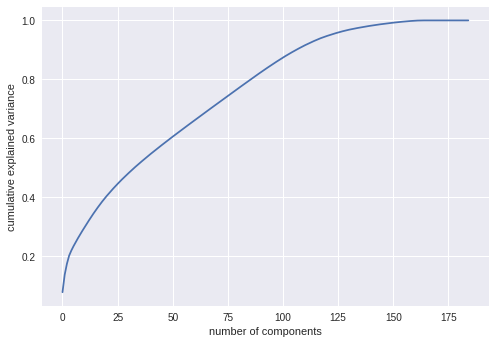

In [108]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

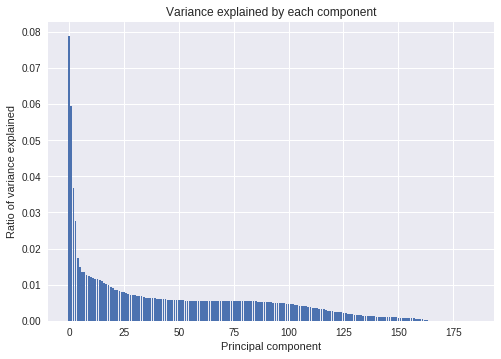

In [109]:
# Investigate the variance accounted for by each principal component.
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.title("Variance explained by each component")
plt.xlabel("Principal component")
plt.ylabel("Ratio of variance explained")
plt.show()

In [110]:
pca_df = pd.DataFrame(pca.components_, columns = general_standard_scaler_df.columns)
pca_df.shape

(185, 185)

In [111]:
# Re-apply PCA to the data while selecting for number of components to retain.
# I decided to retain the first 87 components because they contain 80% of the variance.
pca.explained_variance_ratio_.cumsum()[86]

0.8035980977731193

In [112]:
# Apply PCA to the data and reduce the number of components.
pca_reduced = PCA(n_components=87)

In [113]:
start_time = time.time()
pca_reduced_transformed = pca_reduced.fit_transform(general_standard_scaler_df)
print(type(pca_reduced_transformed.shape), pca_reduced_transformed.shape)
print(f'The time it took to fit and transform the data to reduce components is {time.time() - start_time}')

<class 'tuple'> (794792, 87)
The time it took to fit and transform the data to reduce components is 210.72708702087402


In [114]:
print(pca_reduced.components_.shape, pca_reduced.n_components_)
print(pca_reduced.n_features_, pca_reduced.n_samples_)
print(pca_reduced.explained_variance_ratio_[0])

(87, 185) 87
185 794792
0.0788245555333


In [115]:
print(pca_reduced.explained_variance_)

[ 14.58256112  10.98166611   6.80774083   5.09262684   3.22775955
   2.76304839   2.49527476   2.48088054   2.33912496   2.28695734
   2.22092082   2.19316204   2.1528028    2.11895781   2.06629309
   2.01282595   1.91933476   1.88106363   1.81043703   1.75230686
   1.67014139   1.59693817   1.57391895   1.53479468   1.4970176
   1.44945952   1.42256875   1.3913653    1.33643124   1.33230923
   1.29984396   1.27575686   1.26848536   1.24277686   1.20948424
   1.17649719   1.175395     1.16603054   1.16041539   1.13815325
   1.11971003   1.1034682    1.0956066    1.08555971   1.08000602
   1.07887401   1.06169804   1.05778549   1.05340078   1.05207443
   1.04526519   1.03897184   1.03436142   1.03185175   1.02908363
   1.02816004   1.02436157   1.02331974   1.01958906   1.01615966
   1.01481775   1.01283932   1.01215853   1.01116381   1.01056741
   1.00860056   1.00730221   1.0061263    1.0057735    1.00316788
   1.00113108   0.99877033   0.99728324   0.99656819   0.99563618
   0.991355

In [116]:
print(pca_reduced.explained_variance_ratio_)

[ 0.07882456  0.05936028  0.03679855  0.02752768  0.01744733  0.01493538
  0.01348795  0.01341015  0.0126439   0.01236192  0.01200496  0.01185492
  0.01163676  0.01145381  0.01116914  0.01088013  0.01037477  0.0101679
  0.00978613  0.00947192  0.00902778  0.00863209  0.00850766  0.00829618
  0.00809198  0.00783491  0.00768955  0.00752088  0.00722394  0.00720166
  0.00702617  0.00689597  0.00685667  0.0067177   0.00653774  0.00635944
  0.00635348  0.00630286  0.00627251  0.00615217  0.00605248  0.00596469
  0.00592219  0.00586788  0.00583786  0.00583174  0.0057389   0.00571775
  0.00569405  0.00568688  0.00565007  0.00561606  0.00559114  0.00557757
  0.00556261  0.00555761  0.00553708  0.00553145  0.00551129  0.00549275
  0.00548549  0.0054748   0.00547112  0.00546574  0.00546252  0.00545189
  0.00544487  0.00543851  0.00543661  0.00542252  0.00541151  0.00539875
  0.00539071  0.00538685  0.00538181  0.00535867  0.00534944  0.00533144
  0.00530572  0.00529462  0.00528149  0.00525422  0.

In [117]:
print(pca_reduced.explained_variance_ratio_.cumsum())

[ 0.07882456  0.13818484  0.17498339  0.20251107  0.2199584   0.23489377
  0.24838173  0.26179188  0.27443578  0.2867977   0.29880266  0.31065757
  0.32229433  0.33374814  0.34491728  0.35579741  0.36617218  0.37634007
  0.38612621  0.39559813  0.40462591  0.41325799  0.42176565  0.43006183
  0.43815381  0.44598871  0.45367826  0.46119915  0.46842309  0.47562475
  0.48265093  0.4895469   0.49640357  0.50312128  0.50965902  0.51601846
  0.52237193  0.52867479  0.5349473   0.54109947  0.54715195  0.55311664
  0.55903883  0.56490671  0.57074458  0.57657632  0.58231522  0.58803297
  0.59372702  0.59941391  0.60506398  0.61068004  0.61627117  0.62184874
  0.62741135  0.63296897  0.63850605  0.6440375   0.64954878  0.65504153
  0.66052703  0.66600183  0.67147295  0.67693869  0.68240121  0.6878531
  0.69329797  0.69873648  0.70417309  0.70959561  0.71500712  0.72040588
  0.72579659  0.73118344  0.73656525  0.74192392  0.74727336  0.75260481
  0.75791053  0.76320515  0.76848664  0.77374086  0.

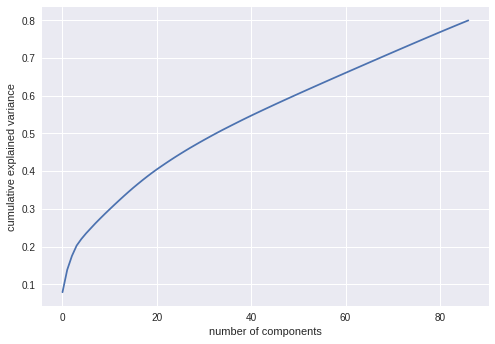

In [118]:
plt.plot(np.cumsum(pca_reduced.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

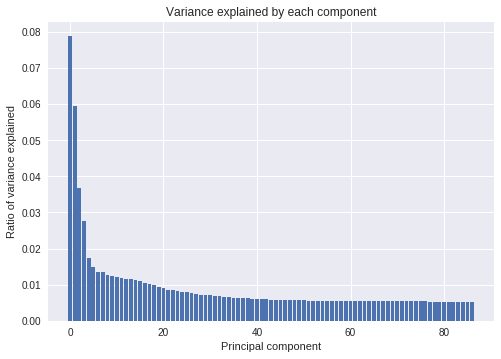

In [119]:
# Investigate the variance accounted for by each principal component.
plt.bar(range(len(pca_reduced.explained_variance_ratio_)), pca_reduced.explained_variance_ratio_)
plt.title("Variance explained by each component")
plt.xlabel("Principal component")
plt.ylabel("Ratio of variance explained")
plt.show()

In [120]:
pca_reduced_df = pd.DataFrame(pca_reduced.components_, columns = general_standard_scaler_df.columns)
pca_reduced_df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_34.0,CAMEO_DEU_2015_35.0,CAMEO_DEU_2015_36.0,CAMEO_DEU_2015_37.0,CAMEO_DEU_2015_38.0,CAMEO_DEU_2015_39.0,CAMEO_DEU_2015_40.0,CAMEO_DEU_2015_41.0,CAMEO_DEU_2015_42.0,CAMEO_DEU_2015_43.0
0,-0.086967,0.011321,-0.189282,0.116461,-0.086948,0.051578,0.053989,0.146321,-0.095727,0.032429,...,0.001866,0.065218,0.045524,0.033764,0.025388,0.039463,0.059426,0.060881,0.059678,0.016887
1,0.234256,0.040856,0.089270,-0.228573,0.220204,-0.206854,-0.216263,0.085587,-0.001783,-0.055008,...,0.012309,0.016253,0.010839,0.016347,0.035291,-0.005523,0.003094,0.007296,0.012878,0.038775
2,0.018694,-0.346159,0.137707,-0.060821,0.051444,-0.157186,-0.047844,-0.067954,0.082042,-0.017794,...,0.001600,0.004311,0.016777,-0.007560,-0.001064,-0.006250,0.008930,0.021797,0.007832,-0.003054
3,-0.039303,0.089877,0.013962,0.012580,-0.023634,-0.065110,0.080166,-0.053258,0.301302,0.000657,...,-0.005689,-0.025717,0.021635,-0.032021,-0.026817,-0.021646,-0.023519,-0.010296,-0.017249,-0.005049
4,0.039101,-0.013336,0.093420,-0.026120,-0.004405,0.030393,-0.096446,-0.116589,-0.035416,0.011726,...,-0.000691,0.038145,-0.021948,0.054556,0.029429,0.064077,0.059139,0.032348,0.023165,-0.017314


In [121]:
pca_reduced_df.shape

(87, 185)

In [122]:
print(f'Program elapse time is {time.time() - initial_start_time}')

Program elapse time is 595.8195779323578


### Discussion 2.2: Perform Dimensionality Reduction
I decided to retain 87 of the components.  The 87 components retain 80 percent of the information of the data, while removing 98 components responsible for 20 percent of the data.

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [123]:
def pca_component_features(df, pca, number):
    components_df = pd.DataFrame(pca.components_, columns = df.columns).iloc[number]
    components_df.sort_values(ascending=False, inplace=True)
    components_df = pd.concat([components_df.head(5), components_df.tail(5)])
    print(components_df)
    components_df.plot(kind='bar', title='Component {number}')
    ax = plt.gca()
    ax.grid(linewidth='0.5', alpha=0.5)
    ax.set_axisbelow(True)
    plt.show()

PLZ8_ANTG3            0.193153
Wealth                0.188811
PLZ8_ANTG4            0.187168
PLZ8_BAUMAX           0.183799
HH_EINKOMMEN_SCORE    0.182178
KBA05_ANTG1          -0.183305
KBA05_GBZ            -0.184886
FINANZ_MINIMALIST    -0.189282
MOBI_REGIO           -0.192413
PLZ8_ANTG1           -0.193530
Name: 0, dtype: float64


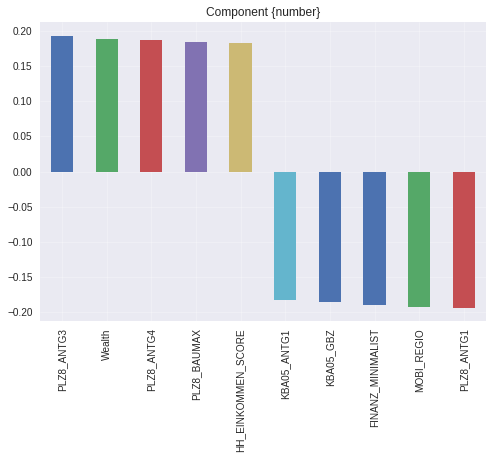

In [124]:
pca_component_features(general_standard_scaler_df, pca_reduced, 0)

ALTERSKATEGORIE_GROB     0.234256
FINANZ_VORSORGER         0.220204
ZABEOTYP_3.0             0.199474
SEMIO_ERL                0.182095
SEMIO_LUST               0.164720
SEMIO_TRADV             -0.209317
FINANZ_UNAUFFAELLIGER   -0.216263
SEMIO_REL               -0.217104
FINANZ_SPARER           -0.228573
Decade                  -0.231272
Name: 1, dtype: float64


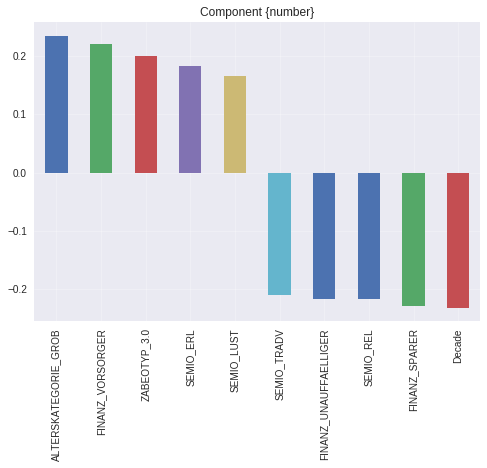

In [125]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
pca_component_features(general_standard_scaler_df, pca_reduced, 1)

SEMIO_VERT           0.321525
SEMIO_FAM            0.258297
SEMIO_SOZ            0.256550
SEMIO_KULT           0.249539
FINANZ_MINIMALIST    0.137707
SEMIO_ERL           -0.206479
SEMIO_KRIT          -0.268687
SEMIO_DOM           -0.283366
SEMIO_KAEM          -0.316787
ANREDE_KZ           -0.346159
Name: 2, dtype: float64


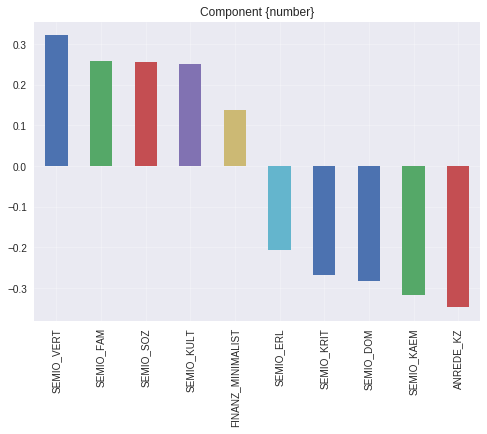

In [126]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_component_features(general_standard_scaler_df, pca_reduced, 2)

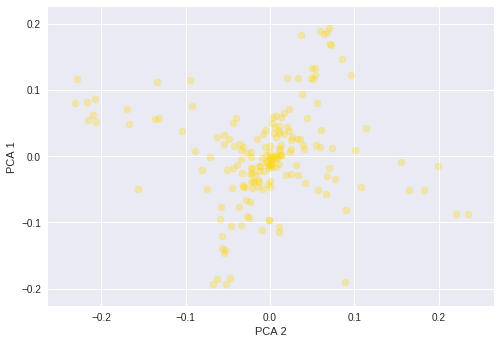

In [127]:
plt.scatter(pca_reduced.components_[1], pca_reduced.components_[0], alpha=.3, color='gold')
plt.xlabel('PCA 2')
plt.ylabel('PCA 1')
plt.show()

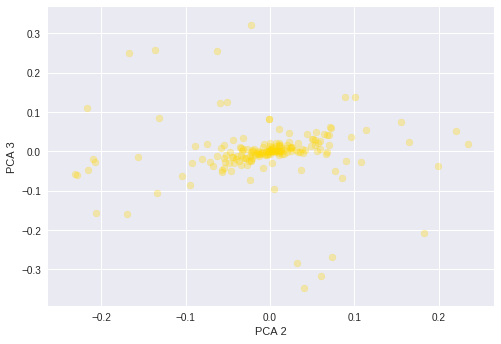

In [128]:
plt.scatter(pca_reduced.components_[1], pca_reduced.components_[2], alpha=.3, color='gold')
plt.xlabel('PCA 2')
plt.ylabel('PCA 3')
plt.show()

#### Discussion 2.3: Interpret Principal Components

**PCA component 0**  has 2 main weights  **PLZ8_ANTG3** and  **PLZ8_ANTG4** which represent the number of family home greater than 6 in the PLZ8 area with a positive correlation.  **PLZ8_ANTG1**, which has the highest negative correlation, indicates 1-2 family homes.

**PCA component 1** main correlating feature, **ALTERSKATEGORIE_GROB** is the estimated age on the analysis of the given name of person. This doesn't appear to be a feature one would want use as a foundation for further data analysis.
The feature with the greatest inverse correlation, **Decade**, in this component is an reengineered feature ""from dominating movement of person's youth" that represents the decades between 1940s to 1990s.

**PCA component 2** major correlating component **SEMIO_VERT** is variable that represents people with a "dreamful" Personality typology. The main inverse correlating component, **ANREDE_KZ** is a feature that represents Gender.

At this point, the information of pca compoments tells us which features of the general population data have the greatest influence.
However it does not tell gives us any insight into the customers data or the relationship between the customer populations and general populations.



## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [129]:
print(f'Program elapse time is {time.time() - initial_start_time}')

Program elapse time is 608.3097412586212


In [130]:
# Our clustering algorithm
BEGIN_CLUSTER = 2
CLUSTER_RANGE = 15

In [131]:
inertias = []
scores = []

start_time = split_time = time.time()
# Over a number of different cluster counts...
for k in range(BEGIN_CLUSTER, CLUSTER_RANGE):
    model = KMeans(n_clusters=k)
    # run k-means clustering on the data and...
    model.fit(pca_reduced_transformed)
    # compute the average within-cluster distances.
    inertias.append(model.inertia_)
    scores.append(model.score(pca_reduced_transformed))
    print(f'total elasped time is {time.time() - start_time}')
    print(f'the time split for {k} clusters is {time.time() - split_time}')
    split_time = time.time()

total elasped time is 53.64670205116272
the time split for 2 clusters is 53.6472601890564
total elasped time is 192.33423709869385
the time split for 3 clusters is 138.6874258518219
total elasped time is 282.91112327575684
the time split for 4 clusters is 90.57677912712097
total elasped time is 378.7420246601105
the time split for 5 clusters is 95.83070039749146
total elasped time is 506.45032811164856
the time split for 6 clusters is 127.70819973945618
total elasped time is 659.8515858650208
the time split for 7 clusters is 153.4011251926422
total elasped time is 824.0420417785645
the time split for 8 clusters is 164.19038558006287
total elasped time is 1100.2948315143585
the time split for 9 clusters is 276.25257086753845
total elasped time is 1333.6366128921509
the time split for 10 clusters is 233.34163355827332
total elasped time is 1596.8770036697388
the time split for 11 clusters is 263.24034214019775
total elasped time is 1953.738088607788
the time split for 12 clusters is 356.

In [132]:
print(f'Program elapse time is {time.time() - initial_start_time}')

Program elapse time is 3125.598111629486


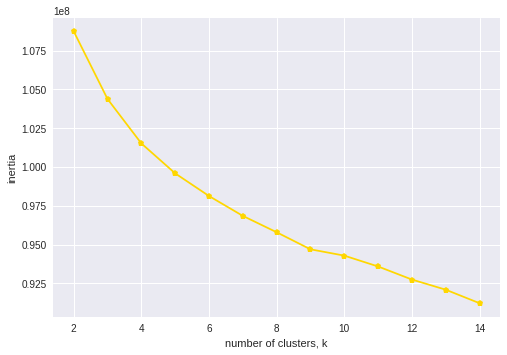

In [133]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(range(BEGIN_CLUSTER, CLUSTER_RANGE), inertias, '-p', color='gold')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.show()

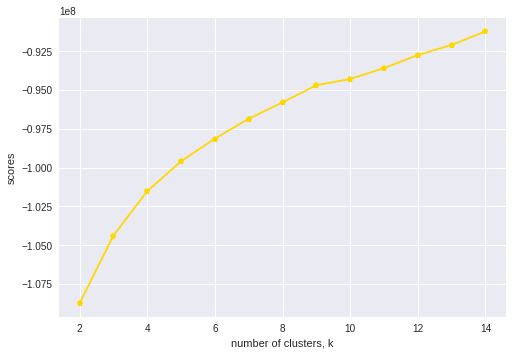

In [134]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(range(BEGIN_CLUSTER, CLUSTER_RANGE), scores, '-p', color='gold')
plt.xlabel('number of clusters, k')
plt.ylabel('scores')
plt.show()

In [135]:
NUMBER_CLUSTERS = 7
cluster_model = KMeans(n_clusters = NUMBER_CLUSTERS) 

In [136]:
# Fit model to samples
start_time = time.time()
cluster_model.fit(pca_reduced_transformed)
print(f'The time it took to fit the cluster model data is {time.time() - start_time}')

The time it took to fit the cluster model data is 132.13669848442078


In [137]:
print(f"The shape of this cluster model is {cluster_model.cluster_centers_.shape}")
cluster_model.cluster_centers_[0]

The shape of this cluster model is (7, 87)


array([ -3.94281681e+00,   9.35789334e-01,  -4.16972159e-01,
        -2.07149612e+00,   2.37063010e-01,   2.54148906e-01,
        -7.41700557e-02,  -3.90050779e-02,   4.17557844e-03,
        -9.78773273e-02,   2.10268425e-01,   5.03353772e-02,
         2.74012083e-02,  -7.53272148e-02,  -2.25415843e-01,
        -1.35314594e-01,   7.17153721e-02,   2.07637115e-02,
         2.88115639e-01,   1.56616063e-01,  -3.87712854e-02,
        -2.26592746e-02,  -2.22492313e-01,   4.23828161e-01,
        -1.36274961e-01,   3.47986972e-01,   2.17358203e-01,
         4.75065036e-02,  -1.59343818e-01,   1.42463173e-01,
        -1.56156847e-01,   5.28094082e-02,   1.13134042e-01,
        -4.66142897e-02,   5.27524164e-02,   8.84505030e-02,
        -6.15319745e-02,  -1.18146077e-01,   9.07397812e-02,
        -3.86537284e-02,  -5.26928259e-02,  -2.72077568e-02,
         4.38128551e-02,   2.17370648e-02,  -1.15478607e-02,
        -2.14832889e-02,  -5.16107500e-03,  -1.54627430e-02,
        -3.07800074e-02,

In [138]:
print(cluster_model.labels_.shape)
cluster_model.labels_[:10]

(794792,)


array([1, 5, 0, 6, 0, 5, 3, 4, 5, 2], dtype=int32)

In [139]:
cluster_transform = cluster_model.transform(pca_reduced_transformed)

In [140]:
cluster_transform.shape

(794792, 7)

In [141]:
cluster_predict = cluster_model.predict(pca_reduced_transformed)

In [142]:
print(cluster_predict.shape)

(794792,)


In [143]:
print(f'Program elapse time is {time.time() - initial_start_time}')

Program elapse time is 3260.095194578171


### Discussion 3.1: Apply Clustering to General Population
As there is no clear elbow, I decided to select the group of 7 clusters.  This model is midpoint in the test range.  This is the best combination of fit speed and accuracy.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [144]:
# Load in the customer demographics data.
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", sep = ';')

In [145]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data
feat_info_orig = pd.read_csv("AZDIAS_Feature_Summary.csv", sep = ';')
customers_df = clean_data(customers, feat_info_orig, removed_columns, row_cutoff_value)
customer_impute_df = impute_func(customers_df, feat_info, imp_categorical_one_hot, imp_categorical_one_binary ,imp_numeric ,imp_ordinal, imp_mixed)
customer_dummies_df = pd.get_dummies(customer_impute_df, columns=categorical_one_hot_list)

In [146]:
# the column GEBAEUDETYP has one vale in the general population and zero in the customer population
# so a column must be added to the customer dataframe
insert_location = customer_dummies_df.columns.get_loc('GEBAEUDETYP_4.0')
customer_dummies_df.insert(loc=insert_location + 1, column='GEBAEUDETYP_5.0', value=0)

In [147]:
# a check to find out if the general and customer dataframes have the same columns
all(general.columns == customer_dummies_df.columns)

True

In [148]:
print(customer_impute_df.index.shape)
customer_scaled_data = standard_scaler.transform(customer_dummies_df)
customer_scaled_data.shape

(141226,)


(141226, 185)

In [149]:
customer_standard_scaler_df = pd.DataFrame(customer_scaled_data, index=customer_dummies_df.index, columns=customer_dummies_df.columns)
customer_pca_reduced_transformed = pca_reduced.transform(customer_standard_scaler_df)
customer_cluster_predict = cluster_model.predict(customer_pca_reduced_transformed)

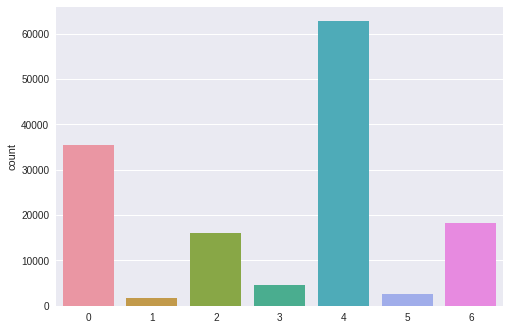

In [150]:
sns.countplot(customer_cluster_predict)

In [151]:
print(f'Program elapse time is {time.time() - initial_start_time}')

Program elapse time is 3266.4133672714233


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [152]:
print(f'Program elapse time is {time.time() - initial_start_time}')

Program elapse time is 3266.4258394241333


The **storage_dict_object** is a dictionary that I am going to use to store the kmeans object and the model.precdict object for both the general and customer data over the range of clusters selected.

The **metric_max_dict** stores the value of the percentage of the dominant cluster in customer cluster group over the percentage of the same cluster in the general population cluster group.

The **metric_min_dict** stores the value of the percentage of the recessive_cluster in the customer cluster group over the percentage of the same cluster in the general population cluster group.

These values will be used the select the cluster group with the most dominant customer cluster and then the recessive cluster of that cluster group.

In [153]:
start_time = split_time = time.time()
storage_dict_object = {}
metric_max_dict = {}
metric_min_dict = {}

print()
for number_of_clusters in range(BEGIN_CLUSTER, CLUSTER_RANGE):    
    model = KMeans(n_clusters=number_of_clusters)
    # run k-means clustering on the data and...
    model.fit(pca_reduced_transformed)

    cluster_predict = model.predict(pca_reduced_transformed)
    customer_cluster_predict = model.predict(customer_pca_reduced_transformed)

    storage_dict_object[number_of_clusters] = {'cluster': cluster_predict, 'customer': customer_cluster_predict, 'model': model}
    
    # Useing the collections library to simplify finding the minimum and maximum values in a dictionary
    cluster_predict_collector = collections.Counter(cluster_predict)
    customer_cluster_predict_collector = collections.Counter(customer_cluster_predict)
    
    predicts_maximum = customer_cluster_predict_collector.most_common(1)
    
    max_customer_value = predicts_maximum[0][1]
    
    matched_genneral_value = cluster_predict_collector[predicts_maximum[0][0]]
    
    metric_maximum = ((max_customer_value / len(customer_cluster_predict)) / (matched_genneral_value / len(cluster_predict)))
    metric_max_dict[number_of_clusters] = metric_maximum

    predicts_minimum = customer_cluster_predict_collector.most_common()[-1]

    min_customer_value = predicts_minimum[1]
    matched_minimum_value = cluster_predict_collector[predicts_minimum[0]]
  
    metric_minimum = ((min_customer_value / len(customer_cluster_predict)) / (matched_minimum_value/ len(cluster_predict)))
    metric_min_dict[number_of_clusters] = metric_minimum    
    
    print(f'total elasped time is {time.time() - start_time}')
    print(f'the time split for {number_of_clusters} clusters is {time.time() - split_time}')
    split_time = time.time()                       


total elasped time is 41.8778281211853
the time split for 2 clusters is 41.878315448760986
total elasped time is 136.85957646369934
the time split for 3 clusters is 94.98162317276001
total elasped time is 207.91286826133728
the time split for 4 clusters is 71.05316543579102
total elasped time is 305.7174253463745
the time split for 5 clusters is 97.80447053909302
total elasped time is 416.6349413394928
the time split for 6 clusters is 110.91738843917847
total elasped time is 548.7595632076263
the time split for 7 clusters is 132.1245036125183
total elasped time is 730.9945003986359
the time split for 8 clusters is 182.23475670814514
total elasped time is 935.9504618644714
the time split for 9 clusters is 204.95580554008484
total elasped time is 1207.2673919200897
the time split for 10 clusters is 271.3168008327484
total elasped time is 1505.658795595169
the time split for 11 clusters is 298.3912456035614
total elasped time is 1801.6358053684235
the time split for 12 clusters is 295.97

**The plots of the cluster groups selected are dispalyed below.**

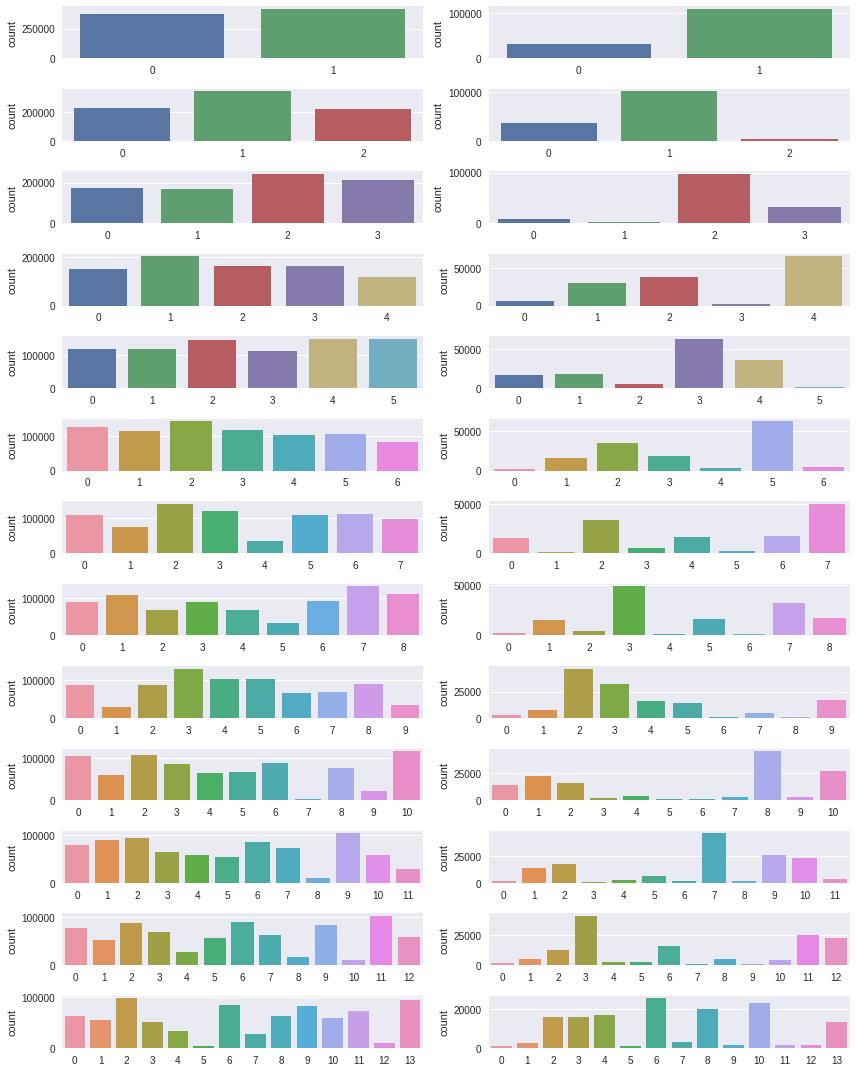

In [154]:
fig, ax =plt.subplots((CLUSTER_RANGE - BEGIN_CLUSTER), 2, figsize=(12, 15))
for number_of_clusters in range(BEGIN_CLUSTER, CLUSTER_RANGE):    
    sns.countplot(storage_dict_object[number_of_clusters]['cluster'], ax=ax[number_of_clusters -BEGIN_CLUSTER,0])
    sns.countplot(storage_dict_object[number_of_clusters]['customer'], ax=ax[number_of_clusters -BEGIN_CLUSTER,1])
plt.tight_layout()
plt.show()

**plot of the dominate cluster metrics for the selected cluster groups.**

In [155]:
metric_max_dict

{2: 1.4864819556790918,
 3: 1.6491038108383893,
 4: 2.259087313257476,
 5: 3.1311970970716096,
 6: 3.16253154592425,
 7: 3.3020029510559348,
 8: 2.9381848752346613,
 9: 3.084051406031857,
 10: 3.0393470143570576,
 11: 3.344581987344105,
 12: 3.5064700345368682,
 13: 3.372516933628437,
 14: 1.6987581876432574}

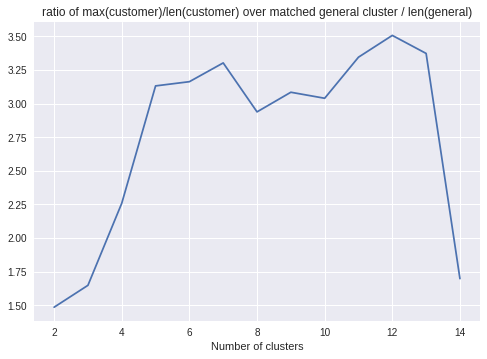

In [156]:
plt.title('ratio of max(customer)/len(customer) over matched general cluster / len(general)')
plt.xlabel("Number of clusters")
plt.plot(*zip(*sorted(metric_max_dict.items())))
plt.show()

**plot of the recessive cluster metrics for the selected cluster groups.**

In [157]:
metric_min_dict

{2: 0.4615405610923222,
 3: 0.08785814434415978,
 4: 0.088854690820817,
 5: 0.09050487919961095,
 6: 0.07566249932267477,
 7: 0.07758355898426192,
 8: 0.09858945416717835,
 9: 0.09318368952064929,
 10: 0.08768675253900035,
 11: 0.09133486686444955,
 12: 0.09519447038641109,
 13: 0.09226936313359786,
 14: 0.0930418193494358}

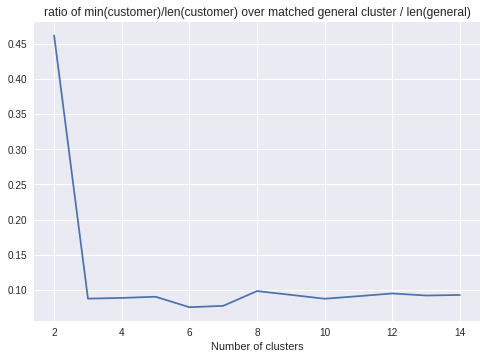

In [158]:
plt.title('ratio of min(customer)/len(customer) over matched general cluster / len(general)')
plt.xlabel("Number of clusters")
plt.plot(*zip(*sorted(metric_min_dict.items())))
plt.show()

### Compare the proportion of data in each cluster for the customer data to the proportion of data in each cluster for the general population.
The customer data plots show much greater variabilty than the gneral population clusters groups, which appear to be much more uniform.  A naive analysis of the data seems to lead to the conclusion that a single dominate customer cluster appears regardless of the the number of clusters.  This will allow us to target this cluster in both the general population with **general_predicts**, and the customer populations with **customer_predicts**.

In [159]:
# Automated selection of the cluster group and the dominant cluster
# Selection of the group of clusters with most dominant single customer cluster. 
best_customer_cluster_group = collections.Counter(metric_max_dict).most_common(1)
print(best_customer_cluster_group)
best_customer_clusters = best_customer_cluster_group[0][0]
best_customer_clusters

[(12, 3.5064700345368682)]


12

In [160]:
# Selection of the most dominant single customer cluster.
dominant_customer_cluster = collections.Counter(storage_dict_object[best_customer_clusters]['customer']).most_common(1)
print(dominant_customer_cluster)
dominant_cluster = dominant_customer_cluster[0][0]
dominant_cluster

[(7, 45453)]


7

In [161]:
# Selection of the most recessive single customer cluster in the selected customer cluster group.
recesssive_list = collections.Counter(storage_dict_object[best_customer_clusters]['customer']).most_common()
print(recesssive_list)
recessive_cluster = recesssive_list[-1][0]
recessive_cluster

[(7, 45453), (9, 25323), (10, 22623), (2, 17030), (1, 13322), (5, 5926), (11, 3140), (4, 2619), (0, 1730), (8, 1694), (6, 1282), (3, 1084)]


3

**Note**
Now that we have selected the group of clusters by means of the max metric and the most dominant and recessive clusters in that cluster group, we can retreive the appropiate general and customer kmeans predict objects.  With these we will create a prediction array for the general and customer data.

In [162]:
#prediction array for the general population group
general_predicts = storage_dict_object[best_customer_clusters]['cluster']
general_predicts.shape, type(general_predicts)

((794792,), numpy.ndarray)

In [163]:
#prediction array for the customer population group
customer_predicts = storage_dict_object[best_customer_clusters]['customer']
customer_predicts.shape, type(customer_predicts)

((141226,), numpy.ndarray)

In [164]:
print(f'Program elapse time is {time.time() - initial_start_time}')

Program elapse time is 5734.17698097229


10 dataframe objects are going to created then stored in **exp_dict**.
The dataframes are:
    1. general population dataframe
    2. customer population dataframe
    3. general data frame  = dominate cluster
    4. general data frame  != dominate cluster
    5. customer data frame  = dominate cluster
    6. customer data frame  != dominate cluster
    7. general data frame  = recessive cluster
    8. general data frame  != recessive cluster
    9. customer data frame  = recessive cluster
    10. customer data frame  != recessive cluster      

In [165]:
# general_dataframe
start_time = time.time()
print(pca_reduced_transformed.shape)
general_data = standard_scaler.inverse_transform(pca_reduced.inverse_transform(pca_reduced_transformed))
general_dataframe = pd.DataFrame(data=general_data,
          columns=general_standard_scaler_df.columns)

print(general_dataframe.shape)
print(time.time() -start_time)

(794792, 87)
(794792, 185)
7.444267511367798


In [166]:
# customer_dataframe
start_time = time.time()
print(customer_pca_reduced_transformed.shape)
customer_data = standard_scaler.inverse_transform(pca_reduced.inverse_transform(customer_pca_reduced_transformed))
customer_dataframe = pd.DataFrame(data=customer_data,
          columns=general_standard_scaler_df.columns)

print(customer_dataframe.shape)
print(time.time() -start_time)

(141226, 87)
(141226, 185)
0.8068974018096924


In [167]:
print(f'Program elapse time is {time.time() - initial_start_time}')

Program elapse time is 5742.5062601566315


In [168]:
# general data frame dominate cluster
start_time = time.time()
print(pca_reduced_transformed.shape)

general_data = standard_scaler.inverse_transform(
    pca_reduced.inverse_transform(pca_reduced_transformed[np.where(general_predicts == dominant_cluster)]))
general_dataframe_dominate_cluster = pd.DataFrame(data=general_data,
          columns=general_standard_scaler_df.columns)

print(general_dataframe_dominate_cluster.shape)
print(time.time() - start_time)

(794792, 87)
(72951, 185)
44.21856880187988


In [169]:
# general data frame not dominate cluster
start_time = time.time()
print(pca_reduced_transformed.shape)

general_data = standard_scaler.inverse_transform(
    pca_reduced.inverse_transform(pca_reduced_transformed[np.where(general_predicts != dominant_cluster)]))
general_dataframe_notdominate_cluster = pd.DataFrame(data=general_data,
          columns=general_standard_scaler_df.columns)

print(general_dataframe_notdominate_cluster.shape)
print(time.time() - start_time)

(794792, 87)
(721841, 185)
132.84420490264893


In [170]:
# customer data frame dominate cluster
start_time = time.time()
print(customer_pca_reduced_transformed.shape)

customer_data = standard_scaler.inverse_transform(
    pca_reduced.inverse_transform(customer_pca_reduced_transformed[np.where(customer_predicts == dominant_cluster)]))
customer_dataframe_dominate_cluster = pd.DataFrame(data=customer_data,
          columns=general_standard_scaler_df.columns)

print(customer_dataframe_dominate_cluster.shape)
print(time.time() - start_time)

(141226, 87)
(45453, 185)
9.578874588012695


In [171]:
# customer data frame not dominate cluster
start_time = time.time()
print(customer_pca_reduced_transformed.shape)

customer_data = standard_scaler.inverse_transform(
    pca_reduced.inverse_transform(customer_pca_reduced_transformed[np.where(customer_predicts != dominant_cluster)]))
customer_dataframe_notdominate_cluster = pd.DataFrame(data=customer_data,
          columns=general_standard_scaler_df.columns)

print(customer_dataframe_notdominate_cluster.shape)
print(time.time() - start_time)  

(141226, 87)
(95773, 185)
0.5746798515319824


In [172]:
print(f'Program elapse time is {time.time() - initial_start_time}')

Program elapse time is 5930.810702800751


In [173]:
# general data frame recessive cluster
start_time = time.time()
print(pca_reduced_transformed.shape)

general_data = standard_scaler.inverse_transform(
    pca_reduced.inverse_transform(pca_reduced_transformed[np.where(general_predicts == recessive_cluster)]))
general_dataframe_recessive_cluster = pd.DataFrame(data=general_data,
          columns=general_standard_scaler_df.columns)

print(general_dataframe_recessive_cluster.shape)
print(time.time() - start_time)

(794792, 87)
(64085, 185)
1.095397710800171


In [174]:
# general data frame not recessive cluster
start_time = time.time()
print(pca_reduced_transformed.shape)

general_data = standard_scaler.inverse_transform(
    pca_reduced.inverse_transform(pca_reduced_transformed[np.where(general_predicts != recessive_cluster)]))
general_dataframe_notrecessive_cluster= pd.DataFrame(data=general_data,
          columns=general_standard_scaler_df.columns)

print(general_dataframe_notrecessive_cluster.shape)
print(time.time() - start_time)

(794792, 87)
(730707, 185)
75.2381181716919


In [175]:
# customer data frame recessive cluster
start_time = time.time()
print(customer_pca_reduced_transformed.shape)

customer_data = standard_scaler.inverse_transform(
    pca_reduced.inverse_transform(customer_pca_reduced_transformed[np.where(customer_predicts == recessive_cluster)]))

customer_dataframe_recessive_cluster = pd.DataFrame(data=customer_data,
          columns=general_standard_scaler_df.columns)

print(customer_dataframe_recessive_cluster.shape)
print(time.time() - start_time)

(141226, 87)
(1084, 185)
0.7243874073028564


In [176]:
# customer data frame not recessive cluster
start_time = time.time()
print(customer_pca_reduced_transformed.shape)

customer_data = standard_scaler.inverse_transform(
    pca_reduced.inverse_transform(customer_pca_reduced_transformed[np.where(customer_predicts != recessive_cluster)]))

customer_dataframe_notrecessive_cluster = pd.DataFrame(data=customer_data,
          columns=general_standard_scaler_df.columns)

print(customer_dataframe_notrecessive_cluster.shape)
print(time.time() - start_time)

(141226, 87)
(140142, 185)
2.273195266723633


In [177]:
print(f'Program elapse time is {time.time() - initial_start_time}')

Program elapse time is 6012.395788192749


In [178]:
exp_dict = {"general_dataframe" :general_dataframe,  
            "customer_dataframe": customer_dataframe,
           "general_dataframe_dominate_cluster" : general_dataframe_dominate_cluster, 
            "general_dataframe_notdominate_cluster": general_dataframe_notdominate_cluster,
            "customer_dataframe_dominate_cluster": customer_dataframe_dominate_cluster, 
            "customer_dataframe_notdominate_cluster": customer_dataframe_notdominate_cluster,
            "general_dataframe_recessive_cluster": general_dataframe_recessive_cluster, 
            "general_dataframe_notrecessive_cluster": general_dataframe_notrecessive_cluster,
            "customer_dataframe_recessive_cluster": customer_dataframe_recessive_cluster,
            "customer_dataframe_notrecessive_cluster": customer_dataframe_notrecessive_cluster}

**Note**

**exp_dict** will be used to calculate the means for the features that will be determined later on.

In [179]:
print(f'Program elapse time is {time.time() - initial_start_time}')

Program elapse time is 6012.45407128334


**Note**

Creating copies of the original general and customer standard scaled dataframes. I will add a target column that contains the cluster labels.  These 2 dataframes will be used as a sanity check to our inverse transform models.  These dataframes will used to plot the target cluster versus the rest of the cluster group.

In [180]:
start_time = time.time()
general_cluster = general_standard_scaler_df.copy()
general_cluster.insert(loc=0, column ="target", value=storage_dict_object[best_customer_clusters]['cluster'])
print(f"the time to copy the general dataframe is {time.time() - start_time}")

the time to copy the general dataframe is 105.4015634059906


In [181]:
start_time = time.time()
customer_cluster = customer_standard_scaler_df.copy()
customer_cluster.insert(loc=0, column = "target", value=storage_dict_object[best_customer_clusters]['customer'])
print(f"the time to copy the customer dataframe is {time.time() - start_time}")

the time to copy the customer dataframe is 32.26639461517334


**Note**

The function **comparison_plot** plots the the sorted inverse transform of the cluster centers of the chosen cluster group.  It also returns the tme most correlated feature name and most inverse correlated feature name.  

These will be used next to calculate the means for the dominant cluster and recessive cluster using **exp_dict**.

In [182]:
def comparison_plot(df, model, cluster):
    inverse_df = pd.DataFrame.from_dict(dict(zip(df.columns,
        pca_reduced.inverse_transform(model.cluster_centers_[cluster]))), orient='index').rename(
        columns={0: 'column_names'}).sort_values('column_names')

    comparison_list = pd.concat((inverse_df['column_names'][:10], inverse_df['column_names'][-10:]), axis=0)
    comparison_list.plot(kind='barh')
    return comparison_list.index[-1], comparison_list.index[0]

In [183]:
best_cluster_model = storage_dict_object[best_customer_clusters]['model']

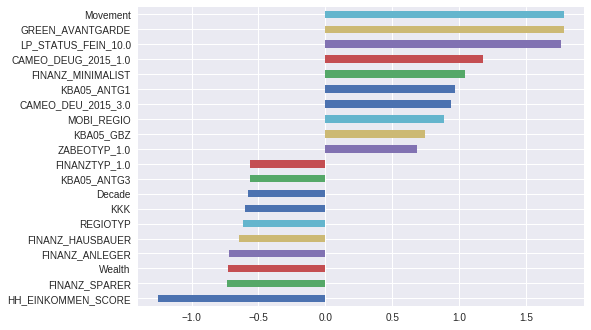

In [184]:
dominate_correlation, dominate_inverse_correlation = comparison_plot(general_standard_scaler_df,
                                                           best_cluster_model, dominant_cluster)

In [185]:
dominate_correlation

'Movement'

In [186]:
dominate_inverse_correlation

'HH_EINKOMMEN_SCORE'

**Note**

Recall the 10 dataframe objects, find the means, and match the the dataframes to their names using **dominate_correlation**.

In [187]:
start_time = time.time()
dominate_correlation_functions = [(key, exp_dict[key][dominate_correlation].mean()) for key in exp_dict.keys()]
print(time.time() -start_time)

425.6126778125763


**Note**

Print the means of the 10 dataframes.

In [188]:
dominate_correlation_functions

[('general_dataframe', 0.21976819092290859),
 ('customer_dataframe', 0.52173707888448961),
 ('general_dataframe_dominate_cluster', 0.95796174297259951),
 ('general_dataframe_notdominate_cluster', 0.14516456240142389),
 ('customer_dataframe_dominate_cluster', 0.98711540158099309),
 ('customer_dataframe_notdominate_cluster', 0.30087273401146525),
 ('general_dataframe_recessive_cluster', 0.10273754187959684),
 ('general_dataframe_notrecessive_cluster', 0.23003209854106543),
 ('customer_dataframe_recessive_cluster', 0.22197534267939525),
 ('customer_dataframe_notrecessive_cluster', 0.52405573940058292)]

**Note**

Recall the 10 dataframe objects, find the means, and match the the dataframes to their names using **dominate_inverse_correlation**.

In [189]:
start_time = time.time()
dominate_inverse_correlation_functions = [(key, exp_dict[key][dominate_inverse_correlation].mean())
                                          for key in exp_dict.keys()]
print(time.time() -start_time)

416.513067483902


**Note**

Print the means of the 10 dataframes.

In [190]:
dominate_inverse_correlation_functions

[('general_dataframe', 4.4189976748633617),
 ('customer_dataframe', 3.3088288577885683),
 ('general_dataframe_dominate_cluster', 2.4890562029276619),
 ('general_dataframe_notdominate_cluster', 4.6140422349800359),
 ('customer_dataframe_dominate_cluster', 2.3543522157375354),
 ('customer_dataframe_notdominate_cluster', 3.7618148435167535),
 ('general_dataframe_recessive_cluster', 5.5545920399069555),
 ('general_dataframe_notrecessive_cluster', 4.3194029469028781),
 ('customer_dataframe_recessive_cluster', 5.0850043870719892),
 ('customer_dataframe_notrecessive_cluster', 3.295090119410756)]

In [191]:
print(f'Program elapse time is {time.time() - initial_start_time}')

Program elapse time is 7008.374729156494


In [192]:
print(general_cluster[general_cluster['target'] ==  dominant_cluster].shape)
print(general_cluster[general_cluster['target'] != dominant_cluster].shape)

(72951, 186)
(721841, 186)


In [193]:
print(f'Program elapse time is {time.time() - initial_start_time}')

Program elapse time is 7283.385317325592


**Note**

The following plot of the general population shows the **dominate_cluster** versus the rest of the cluster group.

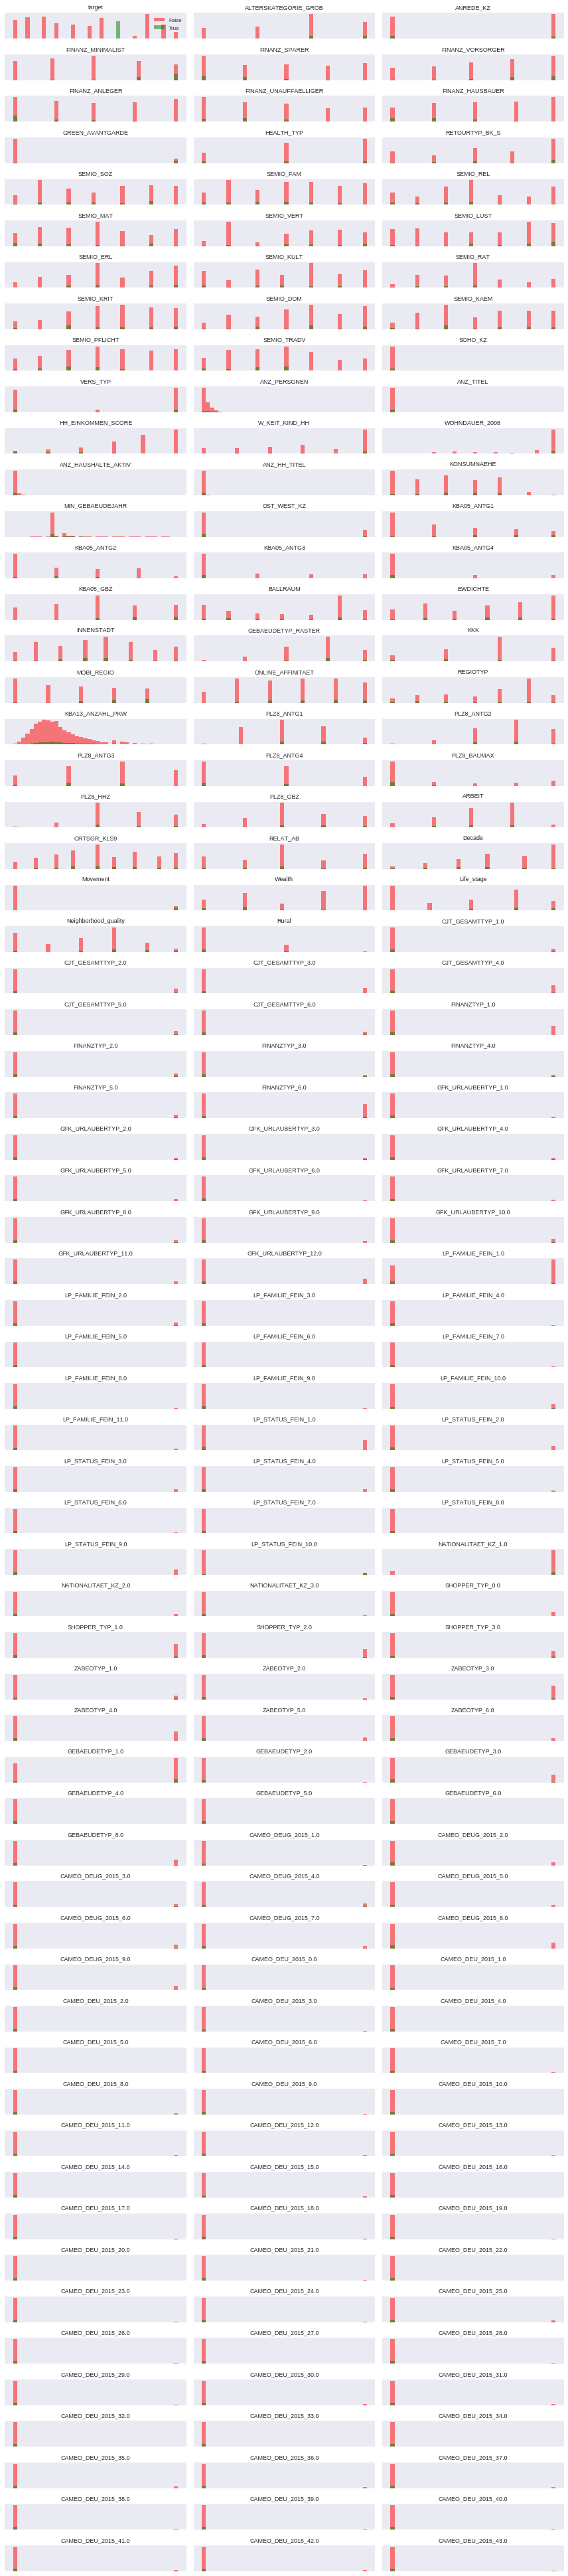

the time to process 186 general population plots is 98.13592982292175


In [194]:
start_time = time.time()
mpl.style.use('seaborn')
true_df = general_cluster[general_cluster['target'] == dominant_cluster]
false_df = general_cluster[general_cluster['target'] != dominant_cluster]

fig,axes =plt.subplots(62,3, figsize=(12, 54)) 
ax=axes.ravel()

for i in range(186):
      _,bins=np.histogram(general_cluster.iloc[:, i],bins=40)
      ax[i].hist(false_df.iloc[:,i],bins=bins,color='r', alpha=0.5, density=None)       
      ax[i].hist(true_df.iloc[:,i],bins=bins,color='g', alpha=0.5, density=None)      
      ax[i].set_title(general_cluster.columns[i],fontsize=9)  
      ax[i].axes.get_xaxis().set_visible(False)
      ax[i].set_yticks(())
ax[0].legend(['False','True'],loc='best',fontsize=8)
plt.tight_layout()
plt.show()
print(f"the time to process 186 general population plots is {time.time() - start_time}")

In [195]:
print(f'Program elapse time is {time.time() - initial_start_time}')

Program elapse time is 7382.062868118286


In [196]:
print(customer_cluster[customer_cluster['target'] == dominant_cluster].shape)
print(customer_cluster[customer_cluster['target'] != dominant_cluster].shape)

(45453, 186)
(95773, 186)


In [197]:
print(f'Program elapse time is {time.time() - initial_start_time}')

Program elapse time is 7399.19535946846


**Note**

The following plot is of the customer population displaying the **dominate_cluster** versus the rest of the cluster group.

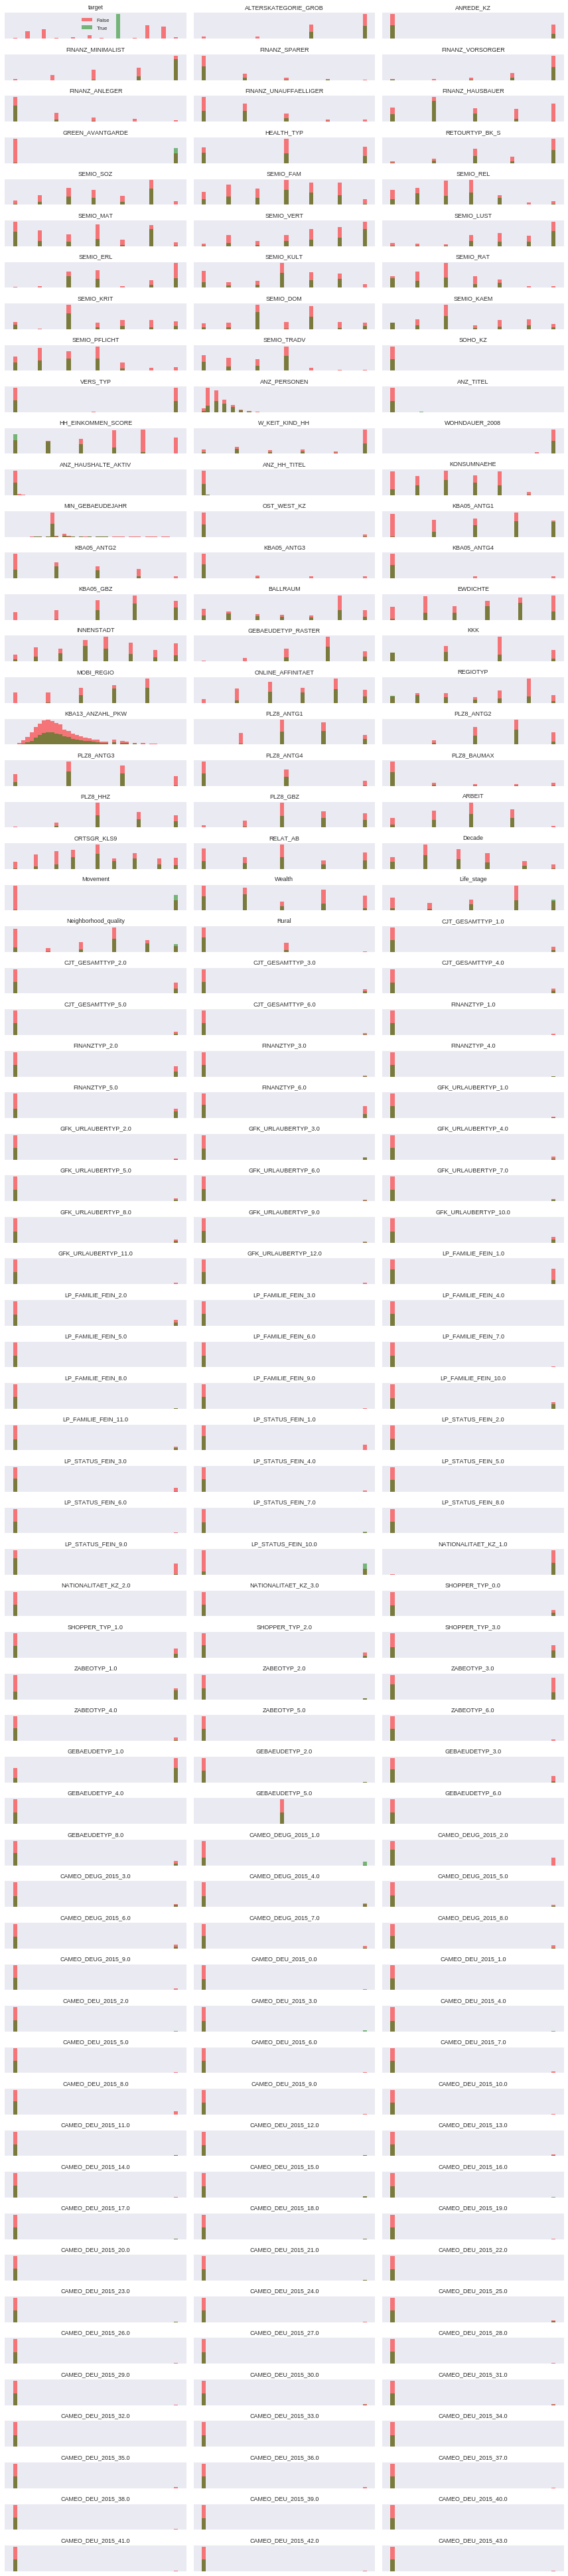

the time to process 186 customer population plots is 48.01040315628052


In [198]:
start_time = time.time()

true_df = customer_cluster[customer_cluster['target'] == dominant_cluster]
false_df = customer_cluster[customer_cluster['target'] !=  dominant_cluster]

fig,axes =plt.subplots(62,3, figsize=(12, 54))
ax=axes.ravel()

for i in range(186):
      _,bins=np.histogram(customer_cluster.iloc[:, i],bins=40)
      ax[i].hist(false_df.iloc[:,i],bins=bins,color='r', alpha=0.5, density=None)    
      ax[i].hist(true_df.iloc[:,i],bins=bins,color='g', alpha=0.5, density=None)       
      ax[i].set_title(customer_cluster.columns[i],fontsize=9)  
      ax[i].axes.get_xaxis().set_visible(False)
      ax[i].set_yticks(())
ax[0].legend(['False','True'],loc='best',fontsize=8)
plt.tight_layout()
plt.show()
print(f"the time to process 186 customer population plots is {time.time() - start_time}")

### What kinds of people are part of a cluster that is overrepresented in the customer data compared to the general population?

The type of people who are overrepresnted in the dominant cluster are people who have minimal financial interest and are people who are involved in movements, particularly green movements. Take a look at the green_avantgarde plot.

**Note**

The same procedure that was used above with the **dominate_cluster** will be followed using the **recessive_cluster**.
First plot the inverse transformed centers.

0.13325285911560059


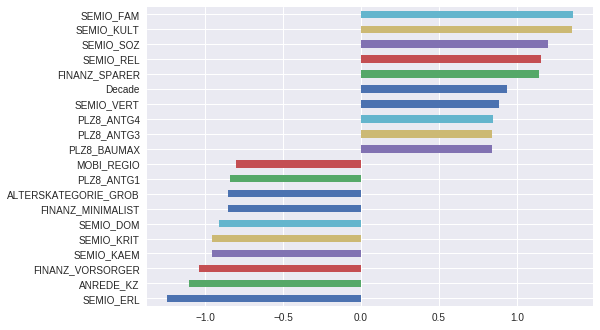

In [200]:
start_time = time.time()
recessive_correlation, recessive_inverse_correlation = comparison_plot(general_standard_scaler_df,
                                                           best_cluster_model, recessive_cluster)
print(time.time() - start_time)

In [201]:
recessive_correlation

'SEMIO_FAM'

In [202]:
recessive_inverse_correlation

'SEMIO_ERL'

**Note**

Recall the 10 dataframe objects, find the means, and match the the dataframes to their names using **recessive_correlation**.

In [203]:
start_time = time.time()
recessive_correlation_functions = [(key, exp_dict[key][recessive_correlation].mean()) for key in exp_dict.keys()]
print(time.time() - start_time)

353.56449365615845


**Note**

Print the means of the 10 dataframes.

In [204]:
recessive_correlation_functions

[('general_dataframe', 4.112350149473067),
 ('customer_dataframe', 3.9275977432184583),
 ('general_dataframe_dominate_cluster', 3.4942415638726922),
 ('general_dataframe_notdominate_cluster', 4.1748177003992861),
 ('customer_dataframe_dominate_cluster', 4.0000610663125302),
 ('customer_dataframe_notdominate_cluster', 3.8932073051555927),
 ('general_dataframe_recessive_cluster', 6.7097037338958074),
 ('general_dataframe_notrecessive_cluster', 3.8845551448299882),
 ('customer_dataframe_recessive_cluster', 6.4361006202521702),
 ('customer_dataframe_notrecessive_cluster', 3.9081944442880556)]

**Note**

Recall the 10 dataframe objects, find the means, and match the the dataframes to their names using **recessive_inverse_correlation**.

In [205]:
start_time = time.time()
recessive_inverse_correlation_functions = [(key, exp_dict[key][recessive_inverse_correlation].mean())                                          for key in exp_dict.keys()]
print(time.time() - start_time)

421.2754650115967


**Note**

Print the means of the 10 dataframes.

In [206]:
recessive_inverse_correlation_functions

[('general_dataframe', 4.6229743127761731),
 ('customer_dataframe', 4.9385805044747251),
 ('general_dataframe_dominate_cluster', 5.1336343343310622),
 ('general_dataframe_notdominate_cluster', 4.5713657740086999),
 ('customer_dataframe_dominate_cluster', 4.7997017486442584),
 ('customer_dataframe_notdominate_cluster', 5.004491106510395),
 ('general_dataframe_recessive_cluster', 2.352122256296088),
 ('general_dataframe_notrecessive_cluster', 4.822134241502086),
 ('customer_dataframe_recessive_cluster', 2.6605800498521108),
 ('customer_dataframe_notrecessive_cluster', 4.9562008644867896)]

In [207]:
print(f'Program elapse time is {time.time() - initial_start_time}')

Program elapse time is 8225.527611732483


In [208]:
print(general_cluster[general_cluster['target'] == recessive_cluster].shape)
print(general_cluster[general_cluster['target'] != recessive_cluster].shape)

(64085, 186)
(730707, 186)


In [209]:
print(f'Program elapse time is {time.time() - initial_start_time}')

Program elapse time is 8390.3272356987


**Note**

The following plot is of the general population displaying the **recessive_cluster** versus the rest of the cluster group.

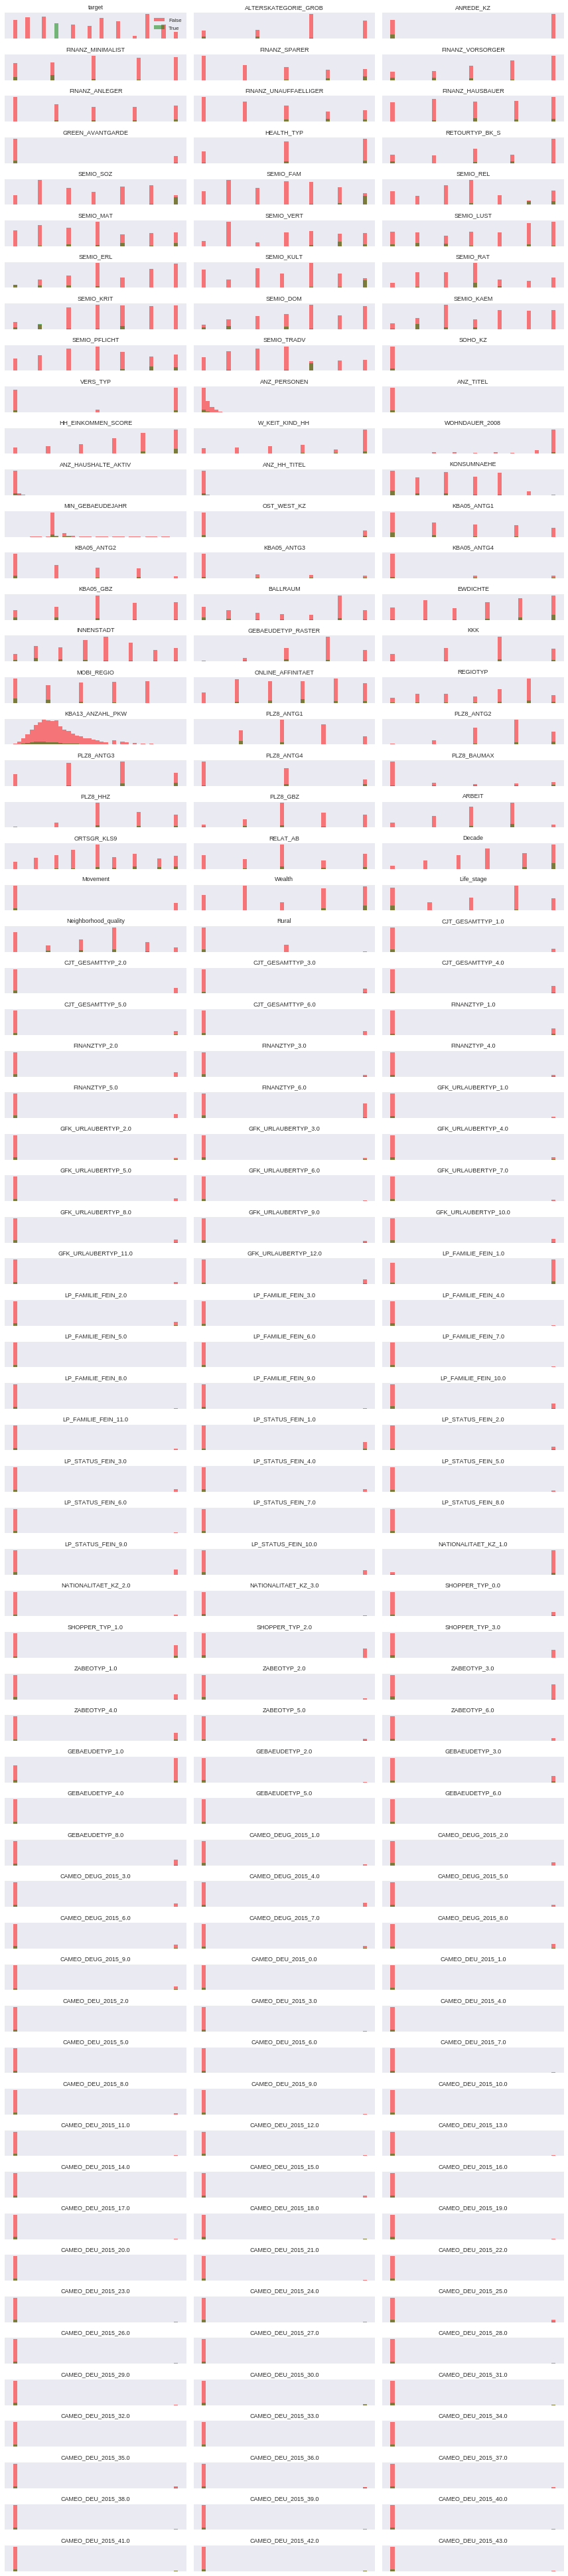

the time to process 186 general population plots is 189.3140857219696


In [210]:
start_time = time.time()
mpl.style.use('seaborn')
true_df = general_cluster[general_cluster['target'] == recessive_cluster]
false_df = general_cluster[general_cluster['target'] != recessive_cluster]

fig,axes =plt.subplots(62,3, figsize=(12, 54))
ax=axes.ravel()

for i in range(186):
      _,bins=np.histogram(general_cluster.iloc[:, i],bins=40)
      ax[i].hist(false_df.iloc[:,i],bins=bins,color='r', alpha=0.5, density=None)      
      ax[i].hist(true_df.iloc[:,i],bins=bins,color='g', alpha=0.5, density=None)    
      ax[i].set_title(general_cluster.columns[i],fontsize=9)  
      ax[i].axes.get_xaxis().set_visible(False)
      ax[i].set_yticks(())
ax[0].legend(['False','True'],loc='best',fontsize=8)
plt.tight_layout()
plt.show()
print(f"the time to process 186 general population plots is {time.time() - start_time}")

In [211]:
print(f'Program elapse time is {time.time() - initial_start_time}')

Program elapse time is 8580.442748308182


In [212]:
print(customer_cluster[customer_cluster['target'] == recessive_cluster].shape)
print(customer_cluster[customer_cluster['target'] != recessive_cluster].shape)

(1084, 186)
(140142, 186)


In [213]:
print(f'Program elapse time is {time.time() - initial_start_time}')

Program elapse time is 8586.081708431244


**Note**

The following plot is of the customer population displaying the **recessive_cluster** versus the rest of the cluster group.

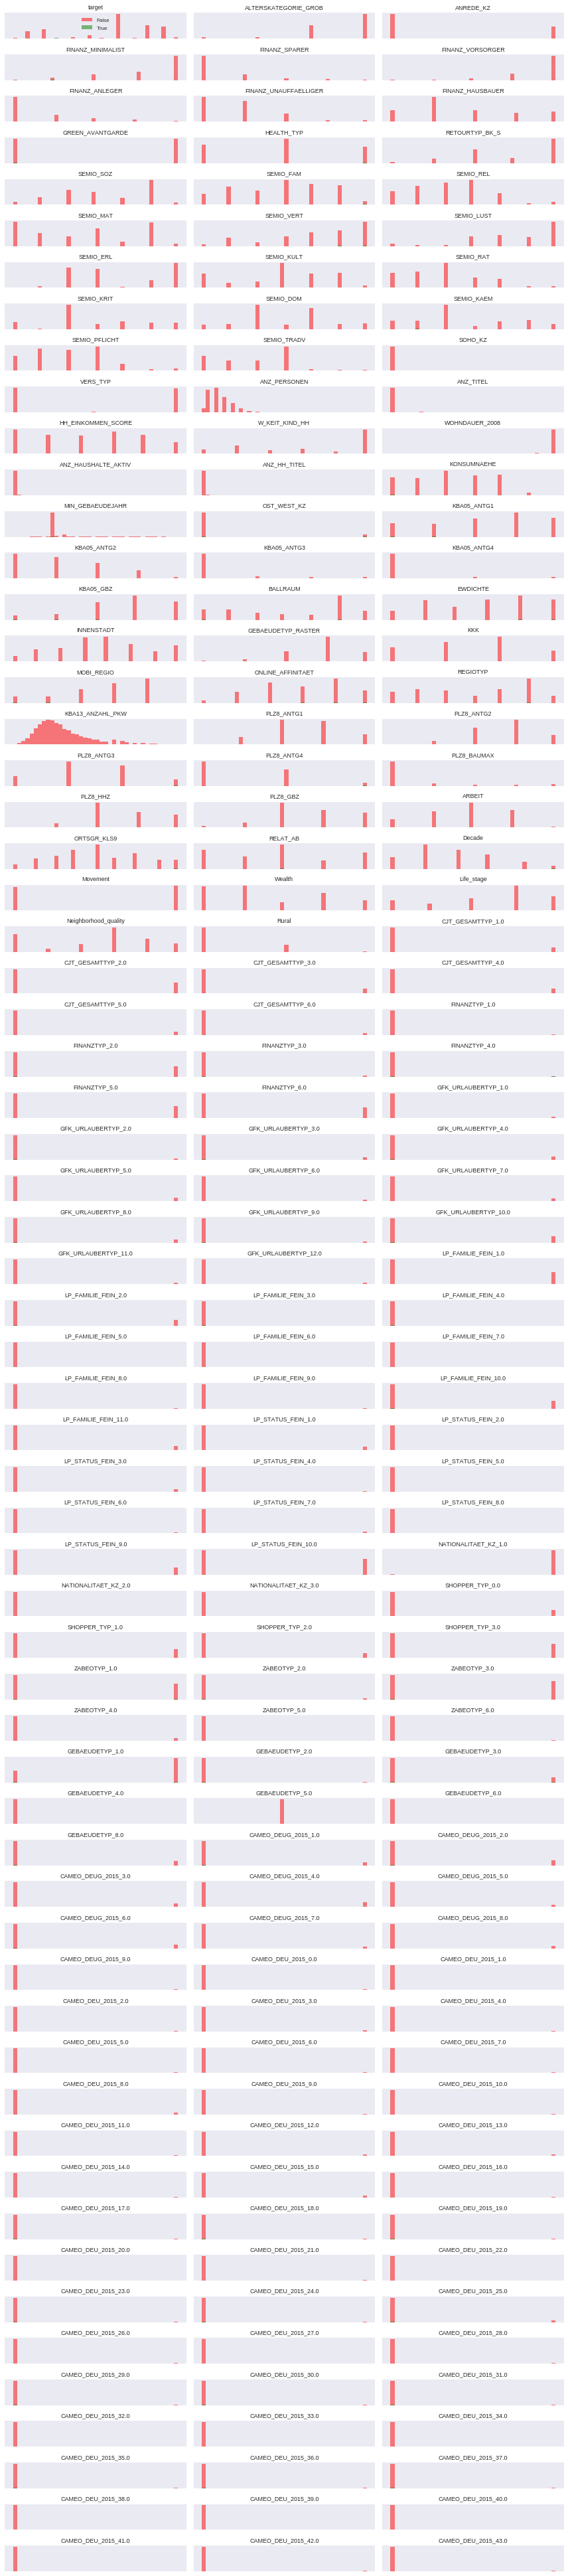

the time to process 186 customer population plots is 47.99476504325867


In [214]:
start_time = time.time()
true_df = customer_cluster[customer_cluster['target'] == recessive_cluster]
false_df = customer_cluster[customer_cluster['target'] !=  recessive_cluster]

fig,axes =plt.subplots(62,3, figsize=(12, 54))
ax=axes.ravel()

for i in range(186):
      _,bins=np.histogram(customer_cluster.iloc[:, i],bins=40)
      ax[i].hist(false_df.iloc[:,i],bins=bins,color='r', alpha=0.5, density=None)        
      ax[i].hist(true_df.iloc[:,i],bins=bins,color='g', alpha=0.5, density=None)     
      ax[i].set_title(customer_cluster.columns[i],fontsize=9)  
      ax[i].axes.get_xaxis().set_visible(False)
      ax[i].set_yticks(())
ax[0].legend(['False','True'],loc='best',fontsize=8)
plt.tight_layout()
plt.show()
print(f"the time to process 186 customer population plots is {time.time() - start_time}")

###  What kinds of people are part of a cluster that is underrepresented in the customer data compared to the general population?

The kind of people underrepresented are people who are interested in the fasmily, the culture and saving money.

In [216]:
print(f'Program elapse time is {time.time() - initial_start_time}')

Program elapse time is 8634.126078605652


In [221]:
[(key, exp_dict[key]['GREEN_AVANTGARDE'].mean()) for key in exp_dict.keys()]

[('general_dataframe', 0.21976819092290859),
 ('customer_dataframe', 0.52173707888448961),
 ('general_dataframe_dominate_cluster', 0.95796174297259951),
 ('general_dataframe_notdominate_cluster', 0.14516456240142389),
 ('customer_dataframe_dominate_cluster', 0.98711540158099309),
 ('customer_dataframe_notdominate_cluster', 0.30087273401146519),
 ('general_dataframe_recessive_cluster', 0.1027375418795969),
 ('general_dataframe_notrecessive_cluster', 0.23003209854106543),
 ('customer_dataframe_recessive_cluster', 0.22197534267939525),
 ('customer_dataframe_notrecessive_cluster', 0.52405573940058292)]

### Discussion 3.3: Compare Customer Data to Demographics Data

The best strategy according to this analysis of the this data is to concentrate on older people interested in the enviromental movement and not that interested in money. As one can see from the info printed above, 98.7 % of the people in the dominate cluster are in the green movement.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.